# Shorter Train Period and PET only

In [1]:
from pathlib import Path
import os
import warnings

%load_ext autoreload
%autoreload 2

# ignore warnings for now ...
warnings.filterwarnings('ignore')

if Path('.').absolute().parents[1].name == 'ml_drought':
    os.chdir(Path('.').absolute().parents[1])

!pwd

/home/tommy/ml_drought


In [2]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import matplotlib as mpl
from tqdm import tqdm
from collections import defaultdict

mpl.rcParams['figure.dpi'] = 150

In [3]:
label_size = 14  # 10
plt.rcParams.update(
    {'axes.labelsize': label_size,
     'legend.fontsize': label_size,
     "font.size": 14,
    }
)

In [4]:
# data_dir = Path('data/')
data_dir = Path('/datadrive/data/')
olddata_dir = Path('/datadrive/olddata/')
# data_dir = Path('/cats/datastore/data/')

assert data_dir.exists()

In [5]:
from src.utils import drop_nans_and_flatten

from src.analysis import read_train_data, read_test_data, read_pred_data
from src.analysis.evaluation import join_true_pred_da
from src.models import load_model

# Read in the CAMELS data

In [6]:
import sys
sys.version

'3.8.10 (default, Jun  4 2021, 15:09:15) \n[GCC 7.5.0]'

In [7]:
# read in the training data
ds = xr.open_dataset(olddata_dir / "RUNOFF/ALL_dynamic_ds.nc")
ds['station_id'] = ds['station_id'].astype(int)

all_static = xr.open_dataset(olddata_dir / f'RUNOFF/interim/static/data.nc')
all_static['station_id'] = all_static['station_id'].astype(int)
static = all_static

# Read all predictions

In [9]:
from scripts.drafts.io_results import read_ensemble_results, read_fuse_data, join_into_one_ds
from scripts.drafts.delta_error import DeltaError


TRAINPERIOD = (1988, 1997)
TESTPERIOD = (1998, 2008)
SAVE = False
RELOAD = True

if RELOAD:
    ## FUSE
    raw_fuse_path = olddata_dir / "RUNOFF/FUSE"
    obs = ds[["discharge_spec"]].sel(time=slice(str(TESTPERIOD[0]), str(TESTPERIOD[1]))).rename({"discharge_spec": "obs"})
    fuse_data = read_fuse_data(raw_fuse_path, obs)
    print("Read FUSE")

    # LSTM
    lstm_ensemble_dir = olddata_dir / "runs/ensemble_LANE"
    lstm_preds = read_ensemble_results(lstm_ensemble_dir, fname="data_ENS.csv")

    all_stations_lstm = np.isin(lstm_preds.station_id, fuse_data.station_id)
    lstm_preds = lstm_preds.sel(
        station_id=all_stations_lstm, time=np.isin(lstm_preds.time, fuse_data.time)
    )
    print("Read LSTM")
    
    ## EALSTM
    ealstm_ensemble_dir = olddata_dir / "runs/ensemble_ealstm_LANE"
    ealstm_preds = read_ensemble_results(ealstm_ensemble_dir, fname="data_ENS.csv")
    all_stations_ealstm = np.isin(ealstm_preds.station_id, fuse_data.station_id)
    ealstm_preds = ealstm_preds.sel(
        station_id=all_stations_ealstm, time=np.isin(ealstm_preds.time, fuse_data.time)
    )
    print("Read EA LSTM")

    all_preds = join_into_one_ds(lstm_preds, fuse_data, ealstm_preds=ealstm_preds)
    
    if SAVE:
        all_preds.to_netcdf(data_dir / "RUNOFF/all_preds_LANE.nc")

else:
    all_preds = xr.open_dataset(data_dir / "RUNOFF/all_preds_LANE.nc")
    
all_preds = all_preds.sel(time=slice("1998", "2008"))
all_preds

Read FUSE
Read LSTM
Read EA LSTM


<xarray.Dataset>
Dimensions:     (station_id: 519, time: 4018)
Coordinates:
  * station_id  (station_id) int64 1001 2001 2002 3003 ... 101005 102001 106001
  * time        (time) datetime64[ns] 1998-01-01 1998-01-02 ... 2008-12-31
Data variables:
    TOPMODEL    (station_id, time) float64 ...
    ARNOVIC     (station_id, time) float64 ...
    PRMS        (station_id, time) float64 ...
    SACRAMENTO  (station_id, time) float64 ...
    obs         (station_id, time) float64 2.14 1.81 4.57 3.3 ... 2.76 2.53 2.33
    LSTM        (station_id, time) float64 1.911 2.133 2.736 ... 1.407 1.284
    EALSTM      (station_id, time) float64 1.899 2.243 2.904 ... 1.677 1.506

# Calculate Metrics

In [10]:
import pickle
from scripts.drafts.calculate_error_scores import calculate_all_data_errors, get_metric_dataframes_from_output_dict

RELOAD = True
SAVE = True

if RELOAD:
    all_errors = calculate_all_data_errors(all_preds, decompose_kge=True, yilmaz_errors=True)
    all_metrics = get_metric_dataframes_from_output_dict(all_errors)
    if SAVE:
        pickle.dump(all_errors, (data_dir / "RUNOFF/all_errors_LANE.pkl").open("wb"))
        pickle.dump(all_metrics, (data_dir / "RUNOFF/all_metrics_LANE.pkl").open("wb"))
    
else:
    all_errors = pickle.load((data_dir / "RUNOFF/all_errors_LANE.pkl").open("rb"))
    all_metrics = pickle.load((data_dir / "RUNOFF/all_metrics_LANE.pkl").open("rb"))
    
metrics_xr = xr.Dataset(all_metrics).rename({"dim_1": "model"})
metrics_xr

Errors: 100%|██████████| 6/6 [04:19<00:00, 43.31s/it]


<xarray.Dataset>
Dimensions:                 (model: 6, station_id: 518)
Coordinates:
  * station_id              (station_id) int64 1001 2001 2002 ... 102001 106001
  * model                   (model) object 'TOPMODEL' 'ARNOVIC' ... 'EALSTM'
Data variables: (12/26)
    sqrt_variability_ratio  (station_id, model) float64 0.8088 0.8934 ... 0.886
    inv_variability_ratio   (station_id, model) float64 0.1439 1.899 ... 0.206
    variability_ratio       (station_id, model) float64 0.8685 0.8701 ... 0.9184
    sqrt_correlation        (station_id, model) float64 0.8857 0.9083 ... 0.9338
    inv_correlation         (station_id, model) float64 0.569 0.294 ... 0.6095
    sqrt_bias_ratio         (station_id, model) float64 1.069 1.115 ... 1.017
    ...                      ...
    nse                     (station_id, model) float64 0.7543 0.7665 ... 0.8587
    kge                     (station_id, model) float64 0.8139 0.7865 ... 0.8884
    mse                     (station_id, model) float64 1.011 0.9605 ... 1.696
    fms                     (station_id, model) float64 -26.17 -27.58 ... -11.56
    flv                     (station_id, model) float64 77.54 -137.4 ... 72.61
    fhv                     (station_id, model) float64 -11.39 -16.28 ... -6.121

# Calculate ∆Metrics

In [11]:
from scripts.drafts.calculate_error_scores import calculate_all_delta_dfs

lstm_delta, _ = calculate_all_delta_dfs(
    all_metrics,
    absolute_metrics=[
            "fms",
            "flv",
            "fhv",
            "bias_error",
            "bias_error_pct",
            "std_error",
            "std_error_pct",
        ],
)

# Explore the Results

In [12]:
from typing import List, Dict, DefaultDict


metrics = ["nse", "kge", "log_nse", "bias_error_pct", "std_error_pct", "correlation"]
metrics = ["nse", "bias_error_pct", "std_error_pct", "correlation", "fms", "flv", "fhv"]
metrics = ["nse", "bias_error", "std_error", "correlation", "fms", "flv", "fhv"]

models = ['TOPMODEL', 'ARNOVIC', 'PRMS', 'SACRAMENTO', "EALSTM", 'LSTM']

summaries = ["mean", "median", "q5"]
summaries = ["median"]

def create_summaries_table(
    all_metrics: DefaultDict[str, Dict],
    metrics: List[str] = ["nse", "bias_error", "std_error", "correlation", "fms", "flv", "fhv"], 
    models: List[str] = ['TOPMODEL', 'ARNOVIC', 'PRMS', 'SACRAMENTO', "EALSTM", 'LSTM'],
    summaries: List[str] = ["median"]
):
    all_summary = []
    for metric in metrics:
        summary_df = all_metrics[metric][models].describe(percentiles=[0.05, 0.5, 0.95]).rename(
            {
                "5%": "q5",
                "50%": "median",
                "95%": "q95",
            }
        ).loc[summaries].T

        if len(summaries) > 1:
            summary_df.columns = pd.MultiIndex.from_arrays(
                ([metric for _ in range(len(summaries))], summaries)
            )
        else:
            summary_df.columns = [metric]

        all_summary.append(summary_df)

    all_metric_summary = pd.concat(all_summary, axis=1)
    return all_metric_summary


all_metric_summary = create_summaries_table(all_metrics, metrics, models, summaries)
all_metric_summary

nse  bias_error  std_error  correlation        fms  \
TOPMODEL    0.761844   -0.038957  -0.095095     0.882474   5.704007   
ARNOVIC     0.780652    0.063110  -0.100167     0.896385   2.253460   
PRMS        0.766325    0.034821  -0.030900     0.890359  35.243480   
SACRAMENTO  0.799887   -0.011675  -0.069853     0.903701  27.909987   
EALSTM      0.851510   -0.017678  -0.109069     0.930998  -6.671185   
LSTM        0.866982   -0.017041  -0.095909     0.936244  -4.306384   

                   flv        fhv  
TOPMODEL     42.218243 -13.038439  
ARNOVIC     -60.335861 -14.657043  
PRMS       -315.245711 -15.107024  
SACRAMENTO -195.916511 -16.194491  
EALSTM       24.868965 -11.574070  
LSTM         23.335129 -10.513278

In [13]:
print(all_metric_summary.to_latex(float_format="%.2f", multirow=True))

\begin{tabular}{lrrrrrrr}
\toprule
{} &  nse &  bias\_error &  std\_error &  correlation &   fms &     flv &    fhv \\
\midrule
TOPMODEL   & 0.76 &       -0.04 &      -0.10 &         0.88 &  5.70 &   42.22 & -13.04 \\
ARNOVIC    & 0.78 &        0.06 &      -0.10 &         0.90 &  2.25 &  -60.34 & -14.66 \\
PRMS       & 0.77 &        0.03 &      -0.03 &         0.89 & 35.24 & -315.25 & -15.11 \\
SACRAMENTO & 0.80 &       -0.01 &      -0.07 &         0.90 & 27.91 & -195.92 & -16.19 \\
EALSTM     & 0.85 &       -0.02 &      -0.11 &         0.93 & -6.67 &   24.87 & -11.57 \\
LSTM       & 0.87 &       -0.02 &      -0.10 &         0.94 & -4.31 &   23.34 & -10.51 \\
\bottomrule
\end{tabular}



In [14]:
all_metric_summary = create_summaries_table(all_metrics, metrics, models, summaries=["q5"])
print(all_metric_summary.to_latex(float_format="%.2f", multirow=True))

\begin{tabular}{lrrrrrrr}
\toprule
{} &   nse &  bias\_error &  std\_error &  correlation &    fms &     flv &    fhv \\
\midrule
TOPMODEL   &  0.37 &       -0.19 &      -0.31 &         0.70 & -48.12 & -330.28 & -30.15 \\
ARNOVIC    &  0.45 &       -0.11 &      -0.27 &         0.78 & -39.68 & -688.29 & -32.75 \\
PRMS       & -0.45 &       -0.12 &      -0.20 &         0.73 & -12.35 & -977.89 & -31.61 \\
SACRAMENTO &  0.20 &       -0.16 &      -0.21 &         0.74 &  -9.73 & -769.29 & -29.91 \\
EALSTM     &  0.66 &       -0.12 &      -0.28 &         0.85 & -26.04 &  -47.42 & -28.59 \\
LSTM       &  0.67 &       -0.13 &      -0.26 &         0.85 & -22.31 &  -67.51 & -25.45 \\
\bottomrule
\end{tabular}



## Check the significance of the differences

In [15]:
from scripts.drafts.statistical_significance import run_test

In [16]:
all_tests = defaultdict(dict)

for metric in ["nse", "bias_error", "std_error", "correlation", "fms", "flv", "fhv"]:
    models = ["TOPMODEL", "PRMS", "SACRAMENTO", "ARNOVIC", "LSTM", "EALSTM"]
    for ref_model in models:
        all_tests[metric][ref_model] = run_test(all_metrics, test="wilcoxon", metric=metric, ref_model=ref_model)

In [17]:
metric = "nse"
all_tests[metric]["LSTM"]

TOPMODEL          PRMS    SACRAMENTO       ARNOVIC  \
statistic  2.103000e+03  1.321000e+03  3.742000e+03  3.155000e+03   
pvalue     2.389656e-81  2.872278e-83  2.131733e-77  8.422260e-79   
p0.01      1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
p0.001     1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   

                 EALSTM  
statistic  1.958200e+04  
pvalue     2.232452e-44  
p0.01      1.000000e+00  
p0.001     1.000000e+00

In [18]:
ref_model = "ARNOVIC"

for metric in all_tests.keys():
#     ref_model = all_metrics[metric].loc[:, models].median().idxmax()
    print(f"{metric} {ref_model} Significant for all:", all_tests[metric][ref_model].loc["p0.01"].sum() >= 5)
    if all_tests[metric][ref_model].loc["p0.001"].sum() <= 4:
        for model in  all_tests[metric][ref_model].columns:
            print(f"\tIs {ref_model} significantly different from {model}", all_tests[metric][ref_model].loc["p0.01", model] == 1)

nse ARNOVIC Significant for all: True
bias_error ARNOVIC Significant for all: False
	Is ARNOVIC significantly different from TOPMODEL True
	Is ARNOVIC significantly different from PRMS False
	Is ARNOVIC significantly different from SACRAMENTO True
	Is ARNOVIC significantly different from LSTM True
	Is ARNOVIC significantly different from EALSTM True
std_error ARNOVIC Significant for all: False
	Is ARNOVIC significantly different from TOPMODEL False
	Is ARNOVIC significantly different from PRMS True
	Is ARNOVIC significantly different from SACRAMENTO True
	Is ARNOVIC significantly different from LSTM False
	Is ARNOVIC significantly different from EALSTM True
correlation ARNOVIC Significant for all: True
fms ARNOVIC Significant for all: False
	Is ARNOVIC significantly different from TOPMODEL False
	Is ARNOVIC significantly different from PRMS True
	Is ARNOVIC significantly different from SACRAMENTO True
	Is ARNOVIC significantly different from LSTM True
	Is ARNOVIC significantly differen

# CDFs

In [19]:
from scripts.drafts.plots import plot_cdf
scale = 0.6
FIGSIZE = (12*scale, 8*scale)

clipping_lookup = {
    "nse": (0, 1.),
    "kge": (0, 1),
    "correlation": (0.5, 1),
    "bias_ratio": (0, 1.5),
    "variability_ratio": (0, 1.5),
    "bias_error": (-0.5, 0.5),
    "std_error": (-0.5, 0.5),
    "bias_error_pct": (-50, 50),
    "std_error_pct": (-50, 50),
    "flv": (-100, 100), 
    "fms": (-100, 100), 
    "fhv": (-100, 100), 
}

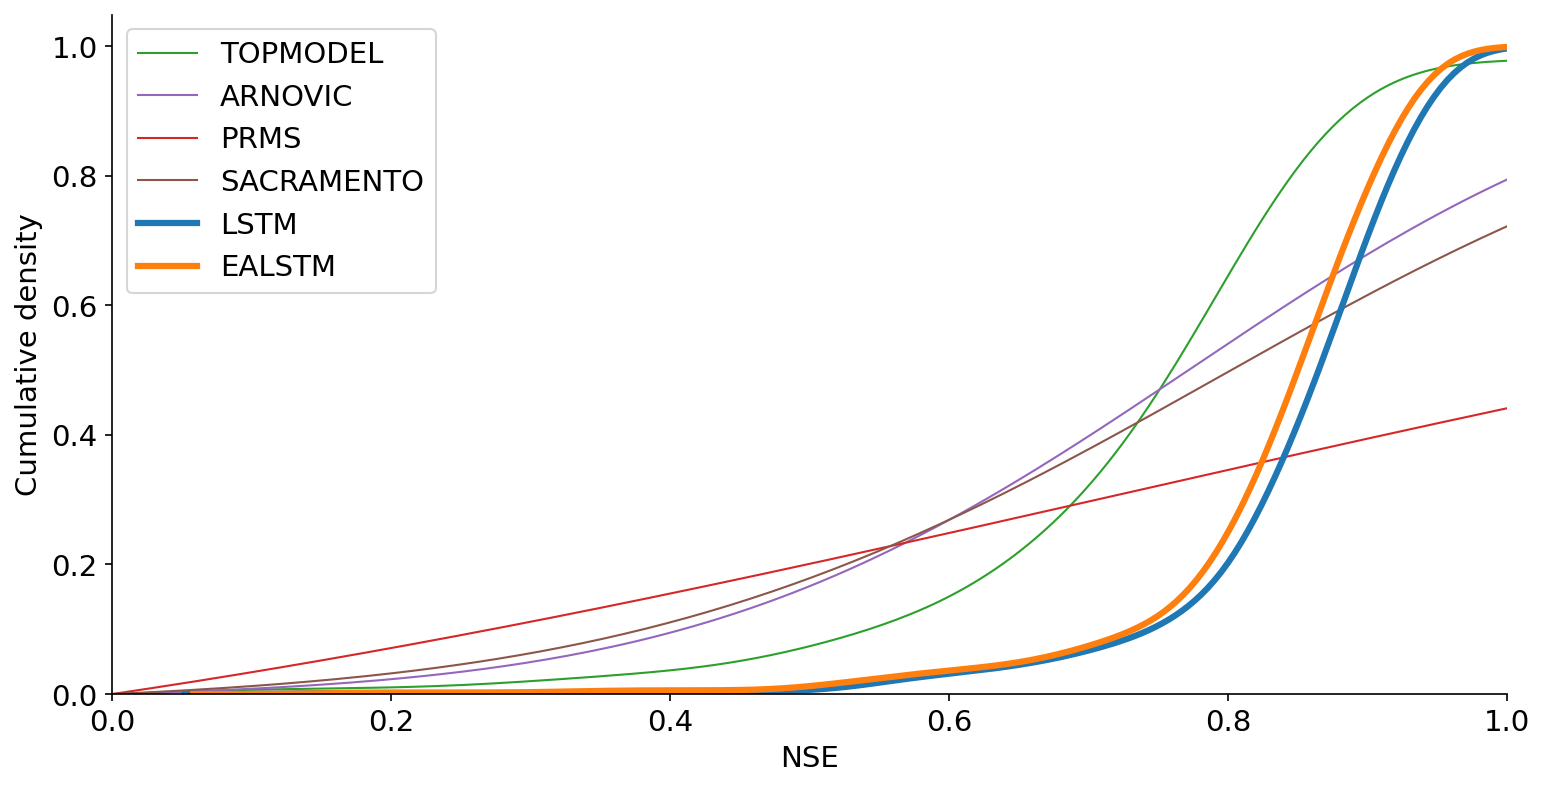

In [20]:
scale = 1.
f, ax = plt.subplots(figsize=(12*scale, 6*scale))
metrics = all_metrics["nse"].drop([c for c in  all_metrics["nse"].columns if "climatology" in c or "persistence" in c], axis=1)
plot_cdf(metrics, metric="NSE", title="", ax=ax, clip=(0, 1), median=True, summary_line=False);

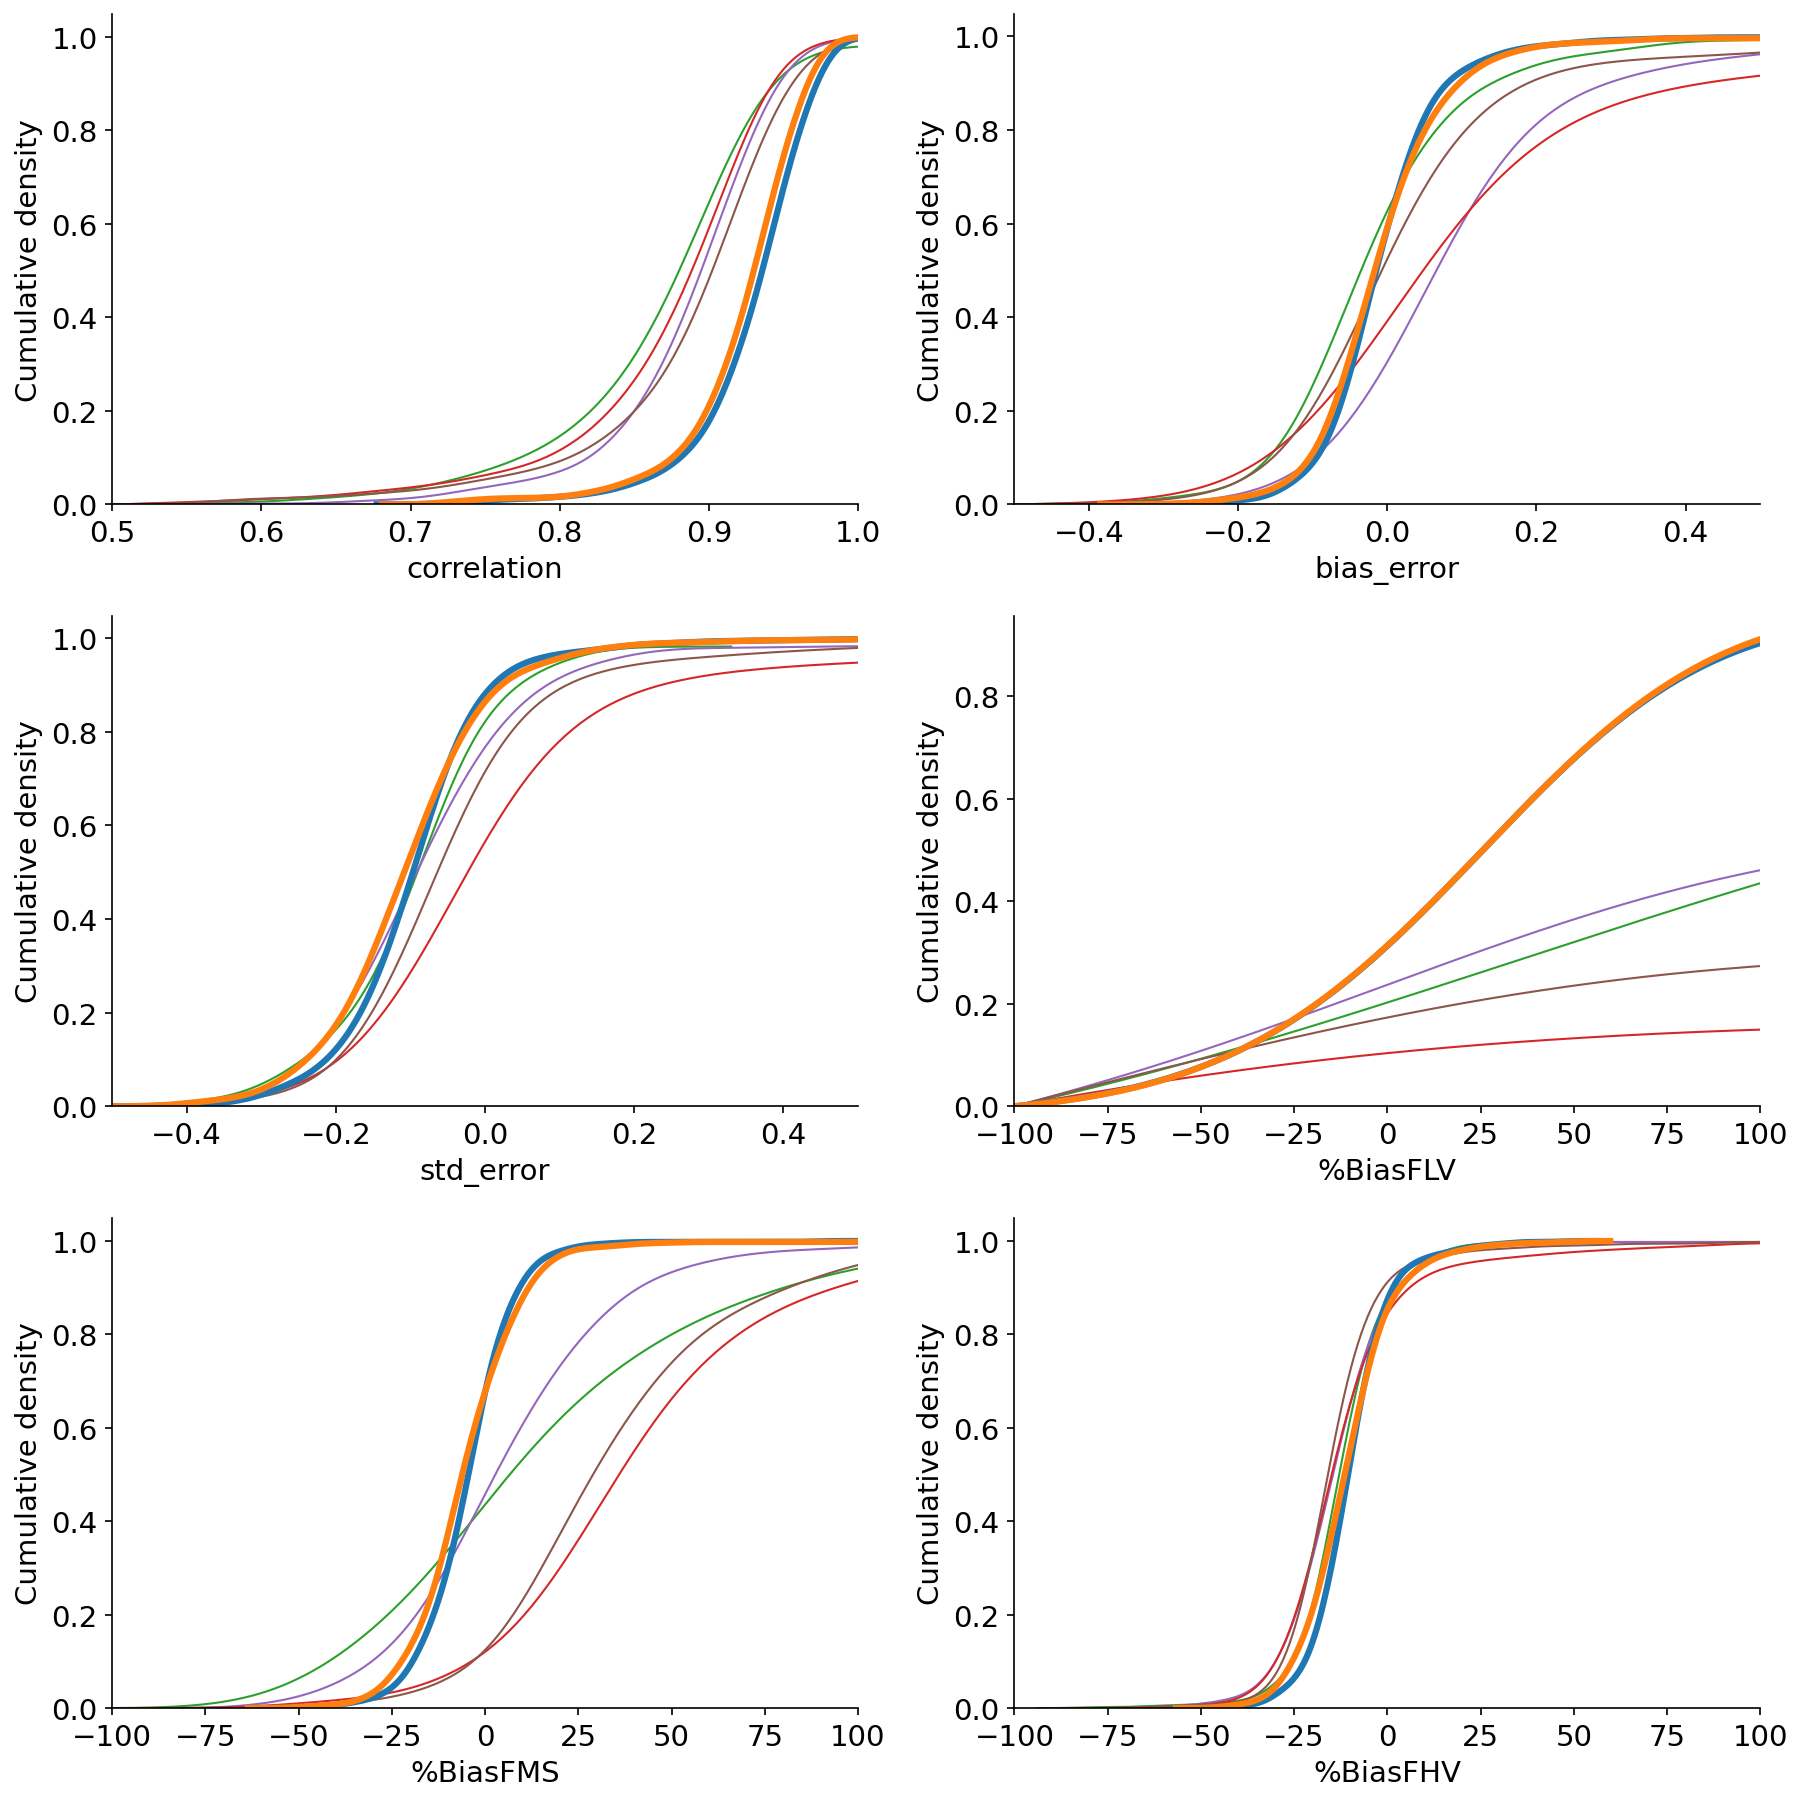

In [21]:
scale = 0.85
f, axs = plt.subplots(3, 2, figsize=(FIGSIZE[0]*2*scale, FIGSIZE[1]*3*scale))

for ix, metric in enumerate(["correlation", "bias_error", "std_error", "flv", "fms", "fhv"]):
    ax = axs[np.unravel_index(ix, (3, 2))]
    metric_data = all_metrics[metric].drop([c for c in  all_metrics[metric].columns if "climatology" in c or "persistence" in c], axis=1)
    plot_cdf(metric_data, metric=metric, title="", ax=ax, clip=clipping_lookup[metric], median=True, summary_line=False, legend=False);
    if metric in ["flv", "fms", "fhv"]:
        ax.set_xlabel(f"%Bias{metric.upper()}")
plt.tight_layout()

# Spatial Plots

In [22]:
import geopandas as gpd

# catchment shapefiles
shp_path = data_dir / "CAMELS_GB_DATASET/Catchment_Boundaries/CAMELS_GB_catchment_boundaries.shp"
assert shp_path.exists()

geo_df = gpd.read_file(shp_path)
geo_df['ID_STRING'] = geo_df['ID_STRING'].astype('int')
geo_df.crs = {'init' :'epsg:27700'}
geo_df.to_crs(epsg=4326)

# Station Gauge lat-lon points (already in EPSG:4326)
d = static[["gauge_lat", "gauge_lon"]].to_dataframe()
points = gpd.GeoSeries(gpd.points_from_xy(d["gauge_lon"], d["gauge_lat"]), index=d.index)
points.name = "geometry"

In [23]:
# wrl = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

In [24]:
assert (data_dir / "RUNOFF/natural_earth_hires/ne_10m_admin_0_countries.shp").exists(), "Download the natural earth hires from https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/10m/cultural/ne_10m_admin_0_countries.zip"

world = gpd.read_file(data_dir / "RUNOFF/natural_earth_hires/ne_10m_admin_0_countries.shp")
uk = world.query("ADM0_A3 == 'GBR'")
# uk.plot(facecolor='none', edgecolor='k')

In [25]:
catchment_ids = [int(c) for c in ["12002", "15006", "27009", "27034", "27041", "39001", "39081", "43021", "47001", "54001", "54057", "71001", "84013",]]
names = static["gauge_name"].to_dataframe()
poly = geo_df.set_index("ID").loc[catchment_ids].join(names).to_crs(epsg=4326)
all_poly = geo_df.set_index("ID").join(names).to_crs(epsg=4326)
pts = gpd.GeoDataFrame(points.loc[catchment_ids]).join(names)
all_points = gpd.GeoDataFrame(points).join(names)

In [26]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from typing import Any, Optional, Dict


markersize = 10
# "scheme": "quantiles" if quantiles else None
opts = {
    "rmse": {"vmin": 0, "vmax": 1, 'cmap': 'viridis', "markersize": markersize},   # rmse   
    "rmse_norm": {"vmin": 0, "vmax": 0.5, 'cmap': 'viridis', "markersize": markersize},   # rmse   
    "nse": {"vmin": 0.6, "vmax": 1, 'cmap': 'viridis_r', "markersize": markersize},    # nse  8
    "log_nse": {"vmin": 0.6, "vmax": 1, 'cmap': 'viridis_r', "markersize": markersize},    # log nse  8
    "kge": {"vmin": 0.7, "vmax": 1, 'cmap': 'cividis_r', "markersize": markersize},    # kge   
    "inv_kge": {"vmin": 0.7, "vmax": 1, 'cmap': 'plasma_r', "markersize": markersize},    # inv kge   
    "mape": {"vmin": 0, "vmax": None, 'cmap': 'plasma_r', "markersize": markersize},    # inv kge   
    "bias": {"vmin": -20, "vmax": 20, 'cmap': 'RdBu', "markersize": markersize},    # bias  
    "abs_pct_bias": {"vmin": 0, "vmax": 50, 'cmap': 'RdBu', "markersize": markersize},    # abs_pct_bias
    "mam30_ape": {"vmin": 0, "vmax": 50, 'cmap': 'RdBu', "markersize": markersize},    # mam30_ape  
    "correlation":{"vmin": 0.85, "vmax": 1, 'cmap': 'plasma_r', "markersize": markersize},
    "bias_ratio":{"vmin": 0.8, "vmax": 1.2, 'cmap': 'RdBu', "markersize": markersize},  
    "variability_ratio":{"vmin": 0.8, "vmax": 1.2, 'cmap': 'RdBu', "markersize": markersize},
    "bias_error":{"vmin": -0.2, "vmax": 0.2, 'cmap': 'RdBu', "markersize": markersize},  
    "std_error":{"vmin": -0.2, "vmax": 0.2, 'cmap': 'RdBu', "markersize": markersize},
    "flv":{"vmin": -100, "vmax": 100, 'cmap': 'RdBu', "markersize": markersize},
    "fms":{"vmin": -25, "vmax": 25, 'cmap': 'RdBu', "markersize": markersize},
    "fhv":{"vmin": -25, "vmax": 25, 'cmap': 'RdBu', "markersize": markersize},
}

from typing import List, Any 


def create_geospatial_data(df: pd.DataFrame) -> gpd.GeoDataFrame:
    return gpd.GeoDataFrame(df.join(points), crs="epsg:4326")


def _add_colorbar(ax: Any, kwargs: Dict[str, float], title: str = ""):
    assert all(np.isin(["cmap", "vmin", "vmax"], [k for k in kwargs.keys()]))
    # get the legend / colorbar
    fig = ax.get_figure()
    cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
    sm = plt.cm.ScalarMappable(cmap=kwargs["cmap"], norm=plt.Normalize(vmin=kwargs["vmin"], vmax=kwargs["vmax"]))
    # fake up the array of the scalar mappable. Urgh...
    sm._A = []
    cbar = fig.colorbar(sm, cax=cax)
    # cbar.set_label('title', rotation=270)


def _plot_geospatial(metric_data: gpd.GeoDataFrame, column: str, ax: Any, legend: bool = True, cax: Optional[Any] = None, kwargs: Dict = {}):
    # plot the chloropleth
    metric_data.to_crs(epsg=4326).plot(column, ax=ax, cax=cax, legend=legend, **kwargs);

    # plot the surrounding lines
    uk.plot(facecolor='none', edgecolor='k', ax=ax, linewidth=0.3)

    ax.set_xlim([-8.2, 2.1])
    ax.set_ylim([50, 59.5])
    ax.axis('off')
    return ax

def plot_geospatial_data_per_model(model_data, model: str, metrics: List[str] = ["nse", "bias", "kge"]):
    assert all(np.isin(metrics, model_data.columns))
    
    n_metrics = len(metrics)
    if n_metrics == 3:
        fig, axs = plt.subplots(1, 3, figsize=(5*n_metrics, 8))
        shape = (1, 3)
    else:
        nrows = (n_metrics // 2) + (n_metrics % 2)
        fig, axs = plt.subplots(nrows, 2, figsize=(5*2, 8*nrows))
        shape = (nrows, 2)
        
    for ix, metric in enumerate(metrics):
        ax = axs[np.unravel_index(ix, shape)]
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.001) # depends on the user needs
        ax = _plot_geospatial(model_data, column=metric, ax=ax, cax=cax, kwargs=opts[metric])
        ax.set_title(metric.upper())
        
    fig.tight_layout()
#     fig.tight_layout(rect=[0, 0.03, 1, 0.965]);
#     fig.suptitle(f"{model} Model Error", size=14);


def plot_geospatial_data_per_metric(metric_data, metric: str, models: List[str] = ["LSTM", "EALSTM", "SACRAMENTO"], legend: bool = False, kwargs: Optional[Dict[str, Any]] = None):
    assert all(np.isin(models, metric_data.columns))
    n_models = len(models)
    
    scale = 0.6
    fig, axs = plt.subplots(1,  n_models, figsize=(5*n_models*scale, 8*scale))
    shape = (n_models,)

    for ix, model in enumerate(models):
        ax = axs[np.unravel_index(ix, shape)]
        
        if legend:
            divider = make_axes_locatable(ax)
            cax = divider.append_axes("right", size="5%", pad=0.001) # depends on the user needs
        else:
            cax = None
        
        # plot the chloropleth
        kwargs = opts[metric] if kwargs is None else kwargs
        ax = _plot_geospatial(metric_data, column=model, ax=ax, kwargs=kwargs, legend=legend, cax=cax)

        ax.set_title(model.upper())
        if not legend:
            pass
    fig.tight_layout()

    
def plot_metric_data_per_season(metric_data, metric="nse", legend: bool = False, kwargs: Optional[Dict[str, Any]] = None):
    seasons = ["DJF", "MAM", "JJA", "SON"]
    assert "season" in metric_data.columns
    assert all(np.isin(seasons, metric_data["season"].unique()))
    n_seasons = len(seasons)
    
    # build the subplot
    scale = 0.6
    fig, axs = plt.subplots(1,  n_seasons, figsize=(5*n_seasons*scale, 8*scale))
    shape = (n_seasons,)

    for ix, season in enumerate(seasons):
        ax = axs[np.unravel_index(ix, shape)]
        
        if legend:
            divider = make_axes_locatable(ax)
            cax = divider.append_axes("right", size="5%", pad=0.001) # depends on the user needs
        else:
            cax = None
        # plot the chloropleth
        kwargs = opts[metric] if kwargs is None else kwargs
        # subset the seasonal points
        plot_data = metric_data.loc[metric_data["season"] == season]
        ax = _plot_geospatial(plot_data, column=metric, ax=ax, kwargs=kwargs, legend=legend, cax=cax)

        ax.set_title(season.upper())
    
    fig.tight_layout()


    return

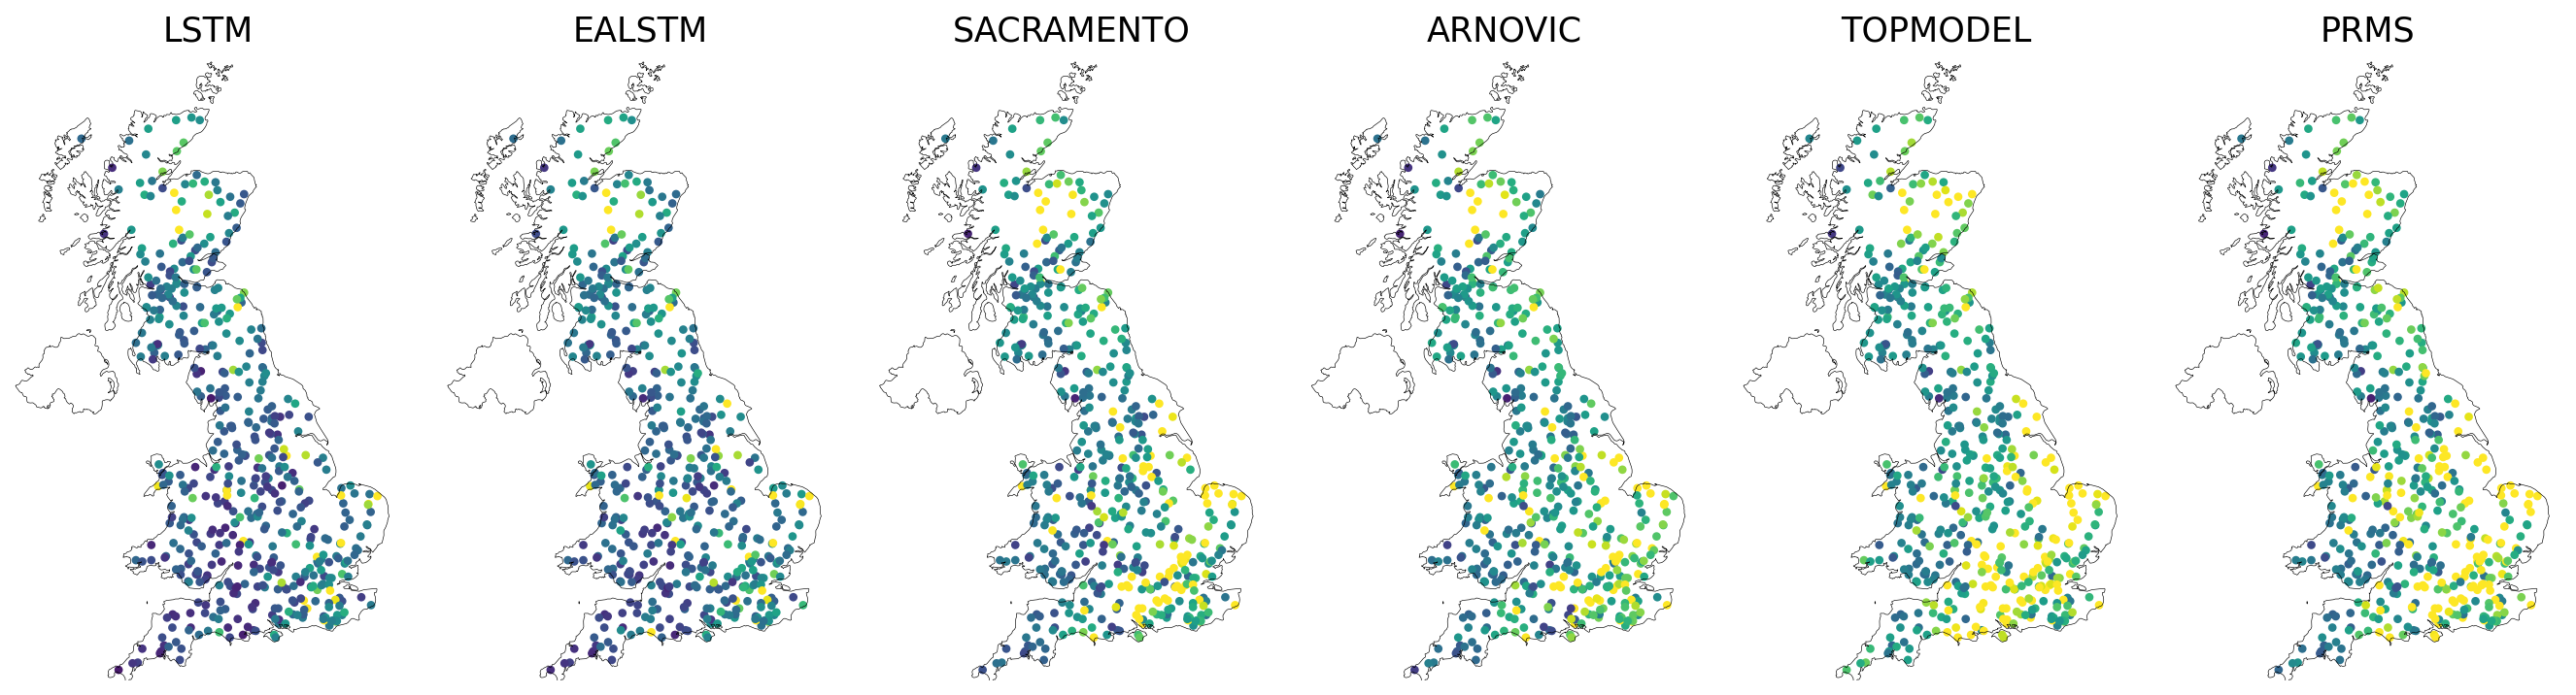

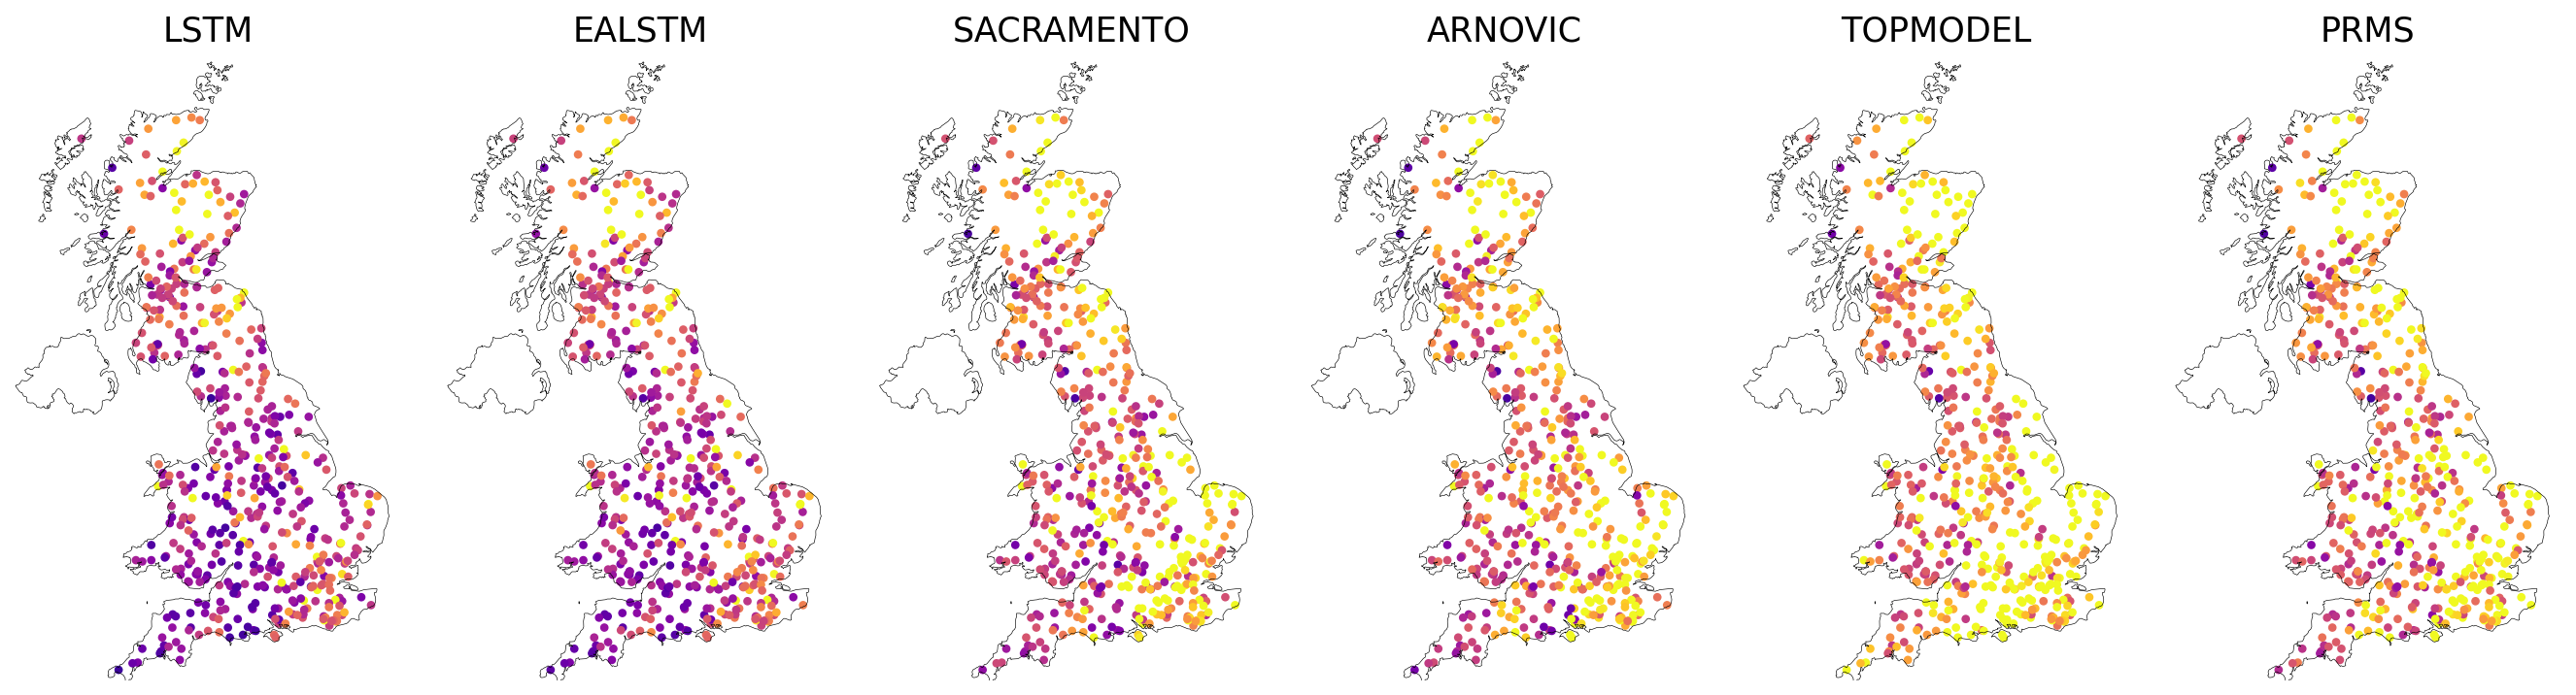

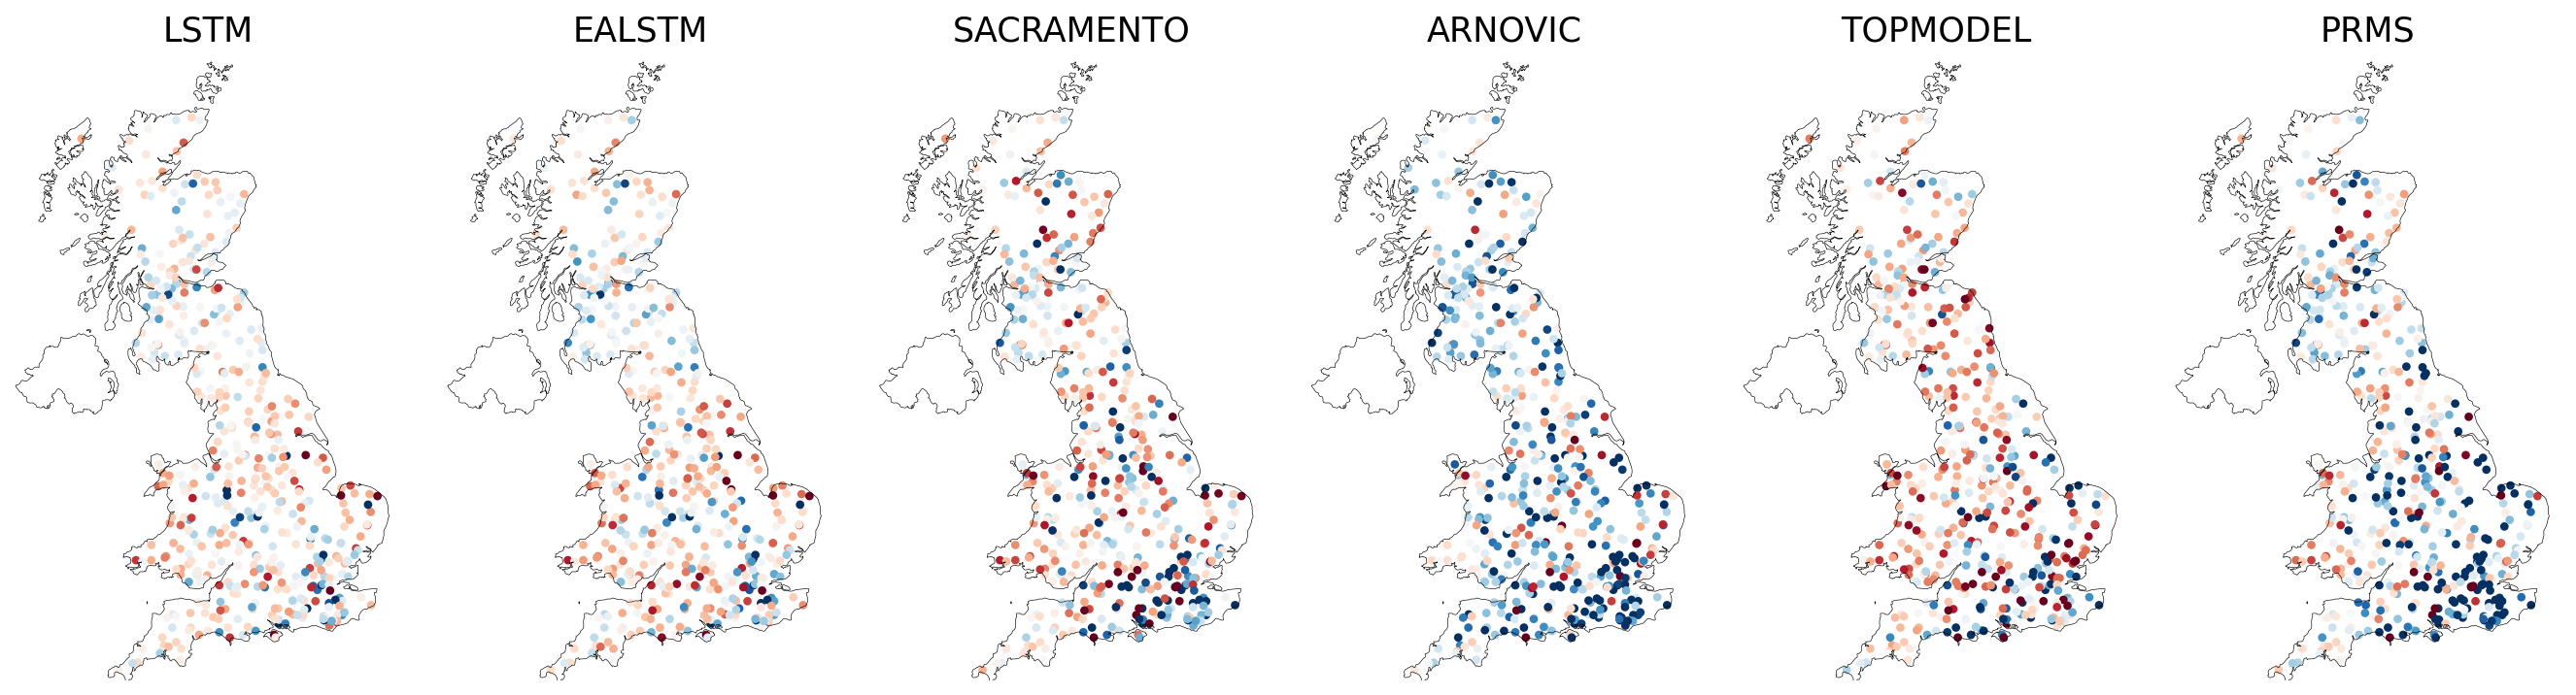

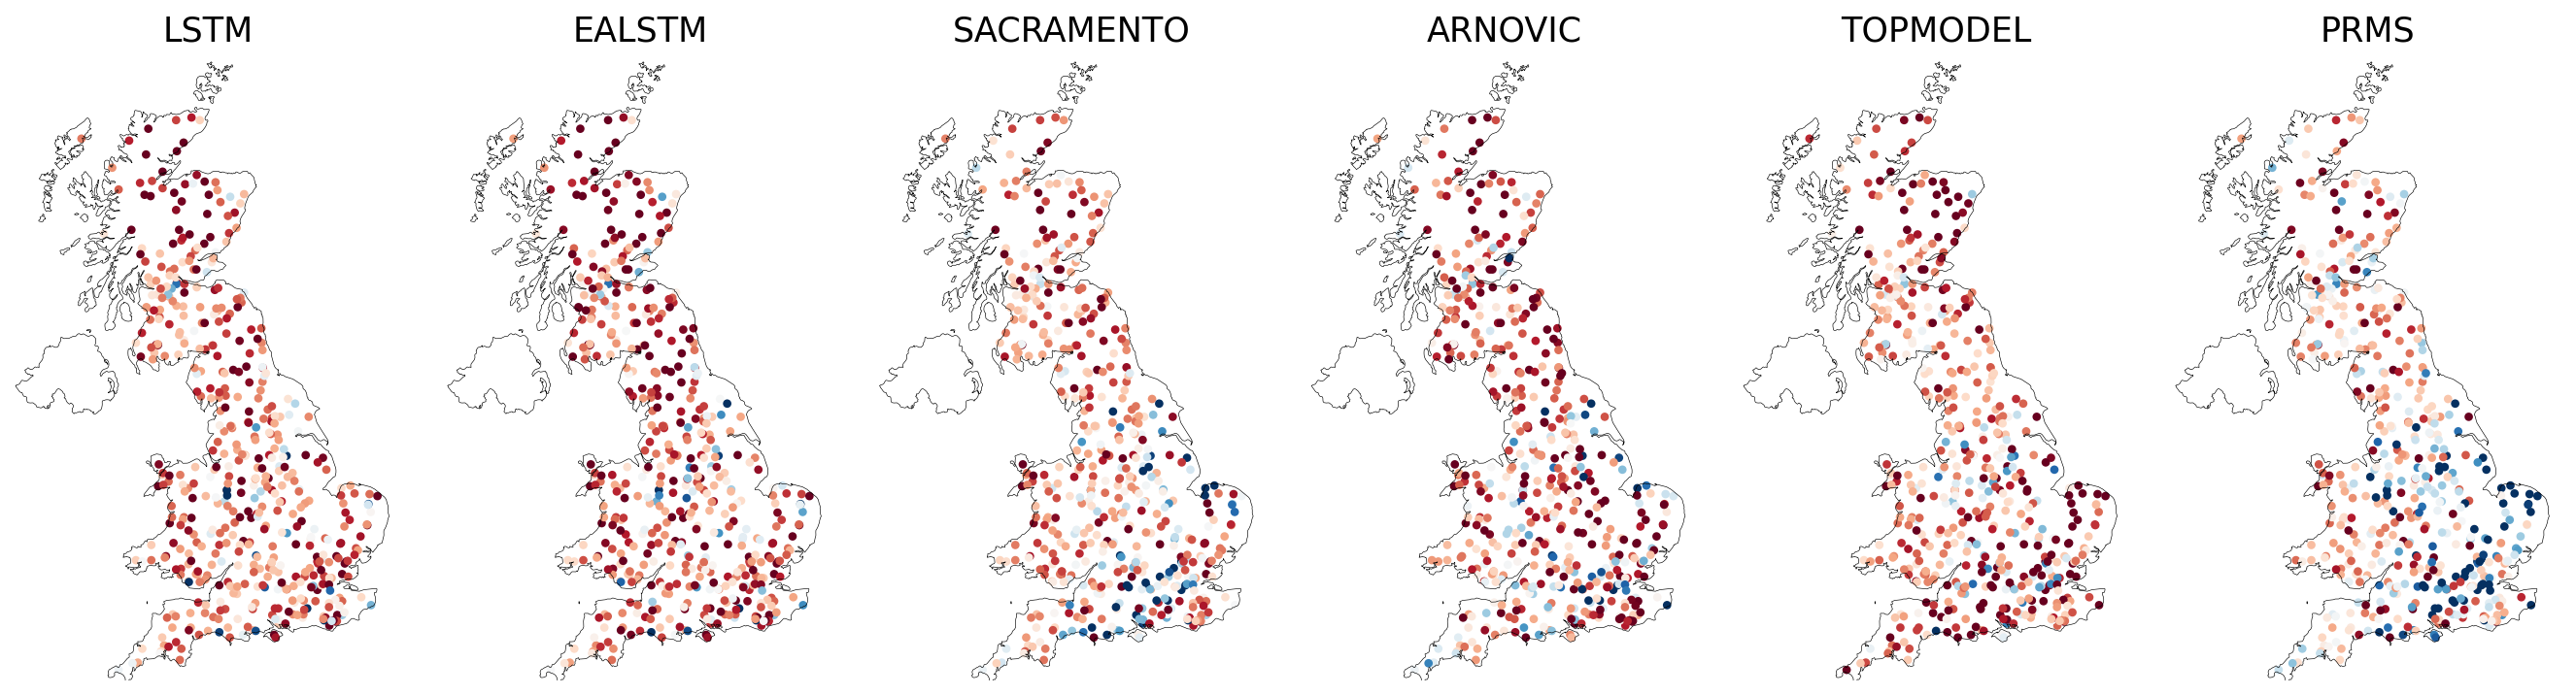

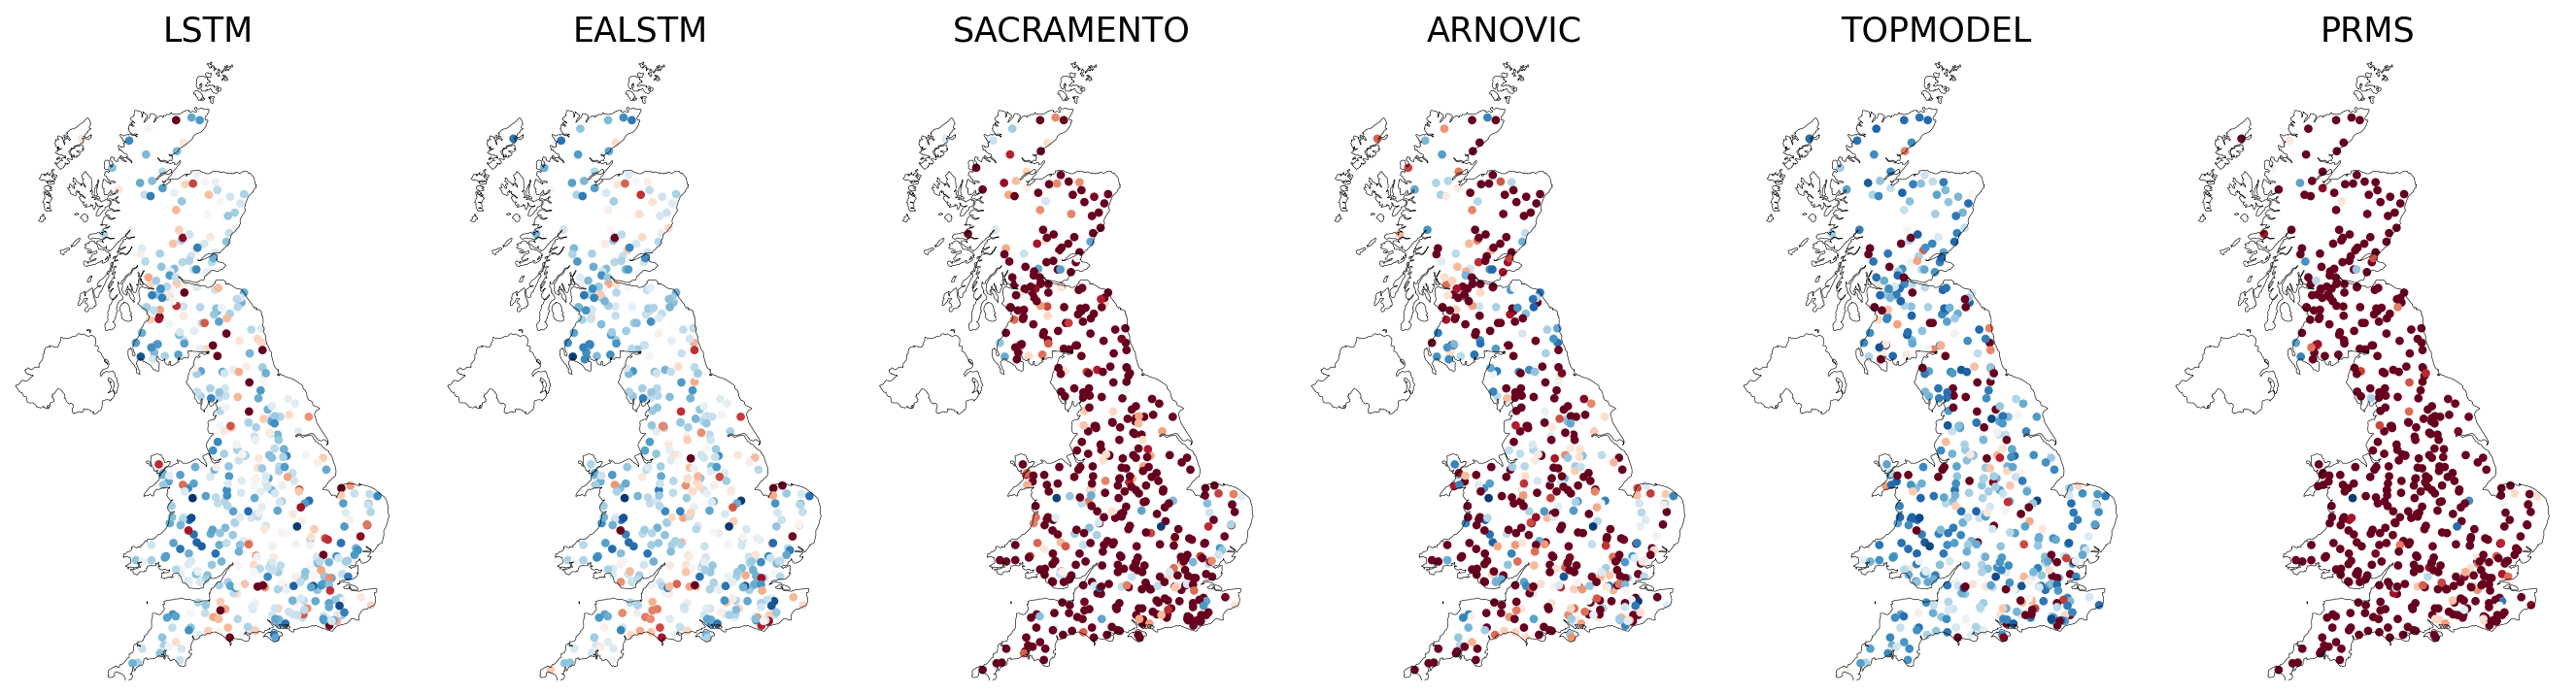

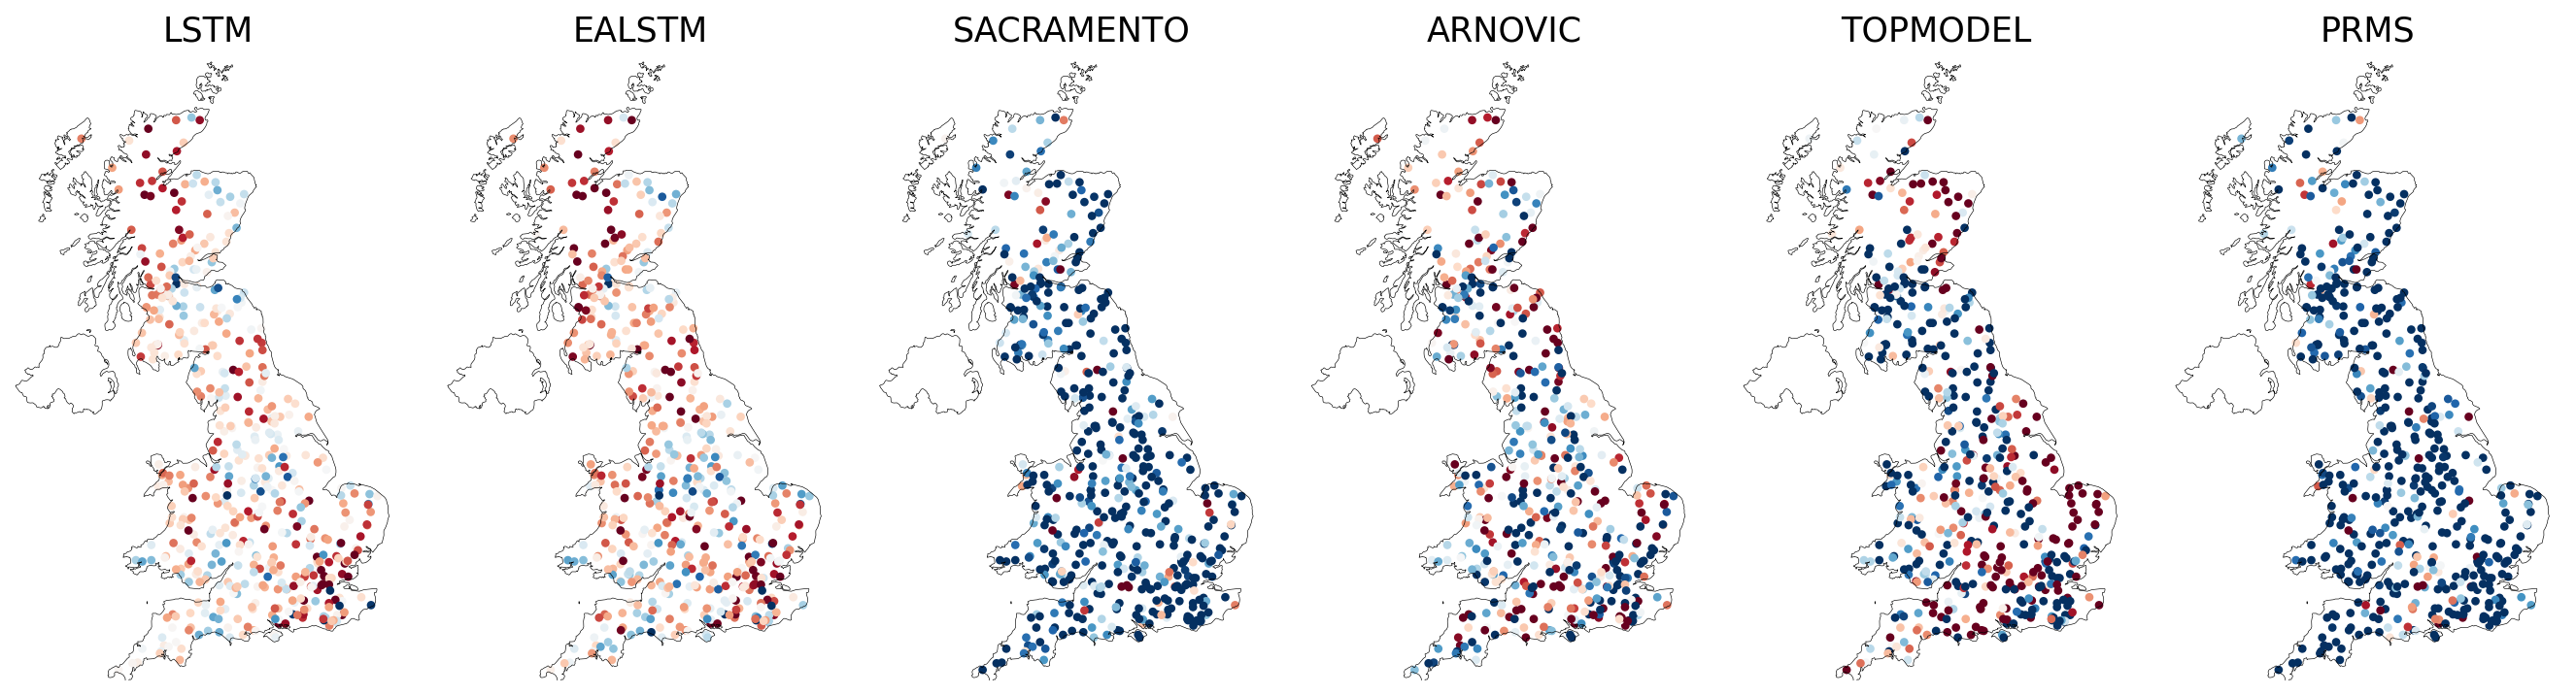

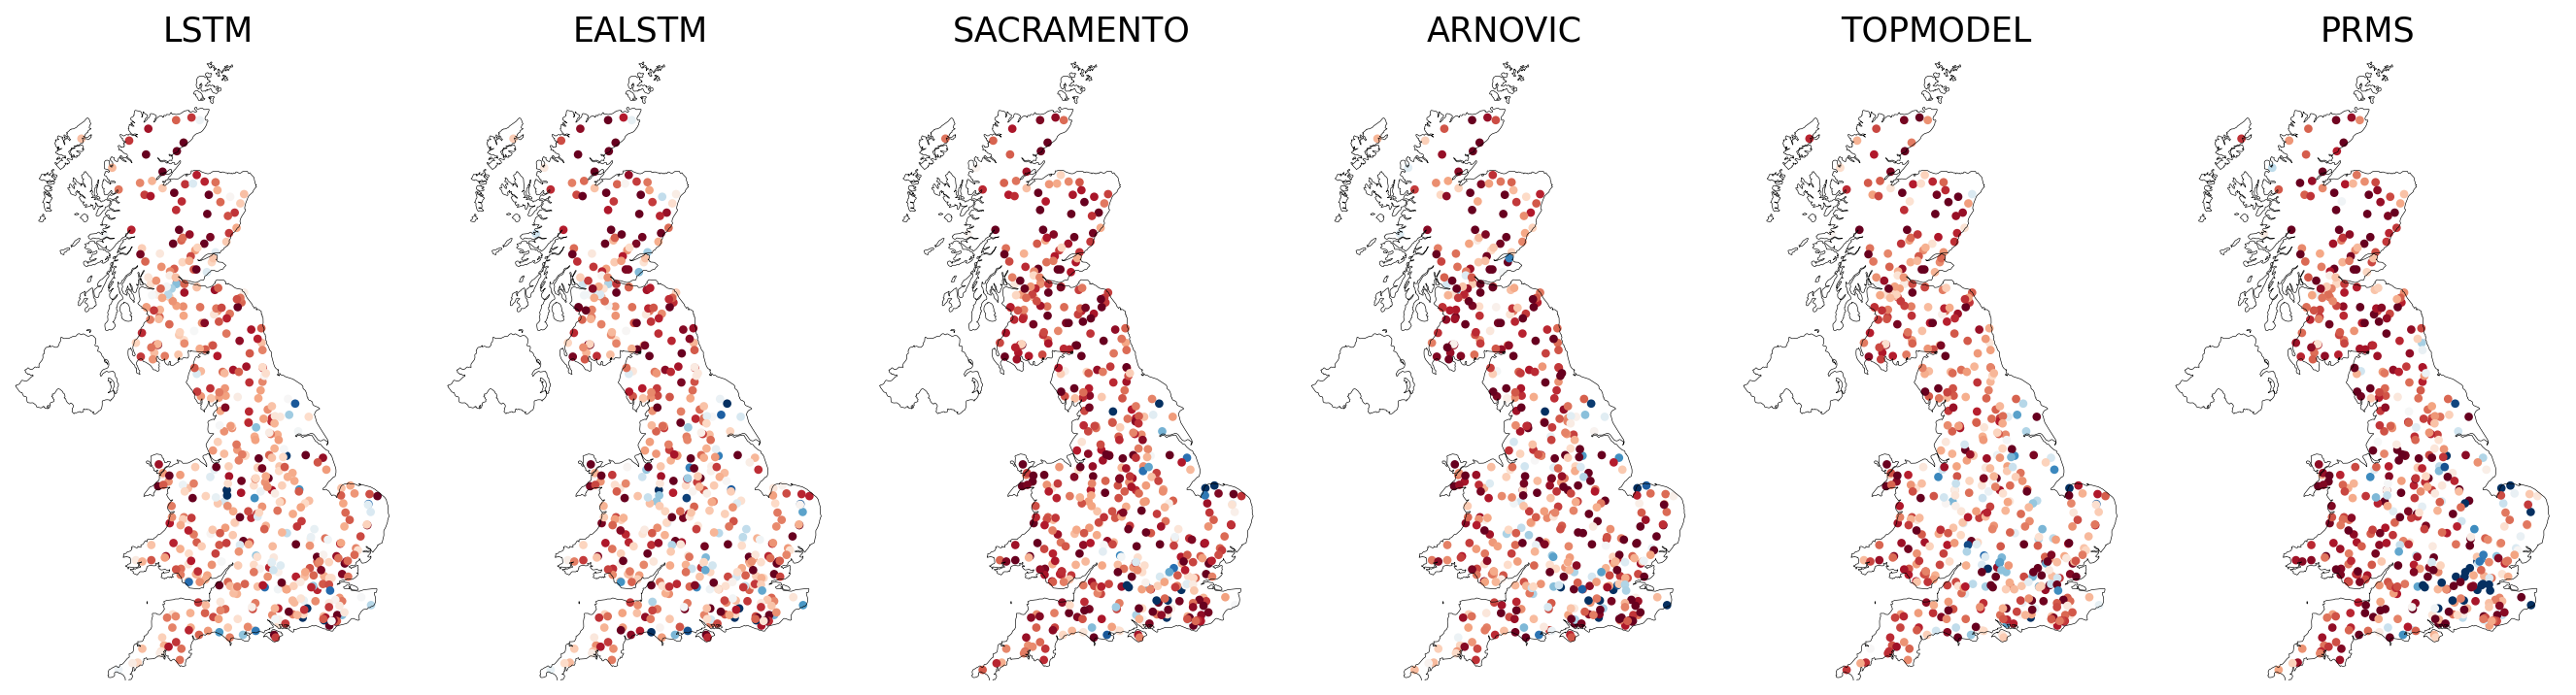

In [27]:
plot_geospatial_data_per_metric(create_geospatial_data(all_metrics["nse"]), metric="nse", models=["LSTM",  "EALSTM", "SACRAMENTO", "ARNOVIC", "TOPMODEL", "PRMS"])
plot_geospatial_data_per_metric(create_geospatial_data(all_metrics["correlation"]), metric="correlation", models=["LSTM", "EALSTM",  "SACRAMENTO", "ARNOVIC", "TOPMODEL", "PRMS"])
plot_geospatial_data_per_metric(create_geospatial_data(all_metrics["bias_error"]), metric="bias_error", models=["LSTM", "EALSTM",  "SACRAMENTO", "ARNOVIC", "TOPMODEL", "PRMS"])
plot_geospatial_data_per_metric(create_geospatial_data(all_metrics["std_error"]), metric="std_error", models=["LSTM",  "EALSTM", "SACRAMENTO", "ARNOVIC", "TOPMODEL", "PRMS"])

# fmv', 'flv', 'fhv
plot_geospatial_data_per_metric(create_geospatial_data(all_metrics["flv"]), metric="flv", models=["LSTM", "EALSTM",  "SACRAMENTO", "ARNOVIC", "TOPMODEL", "PRMS"])
plot_geospatial_data_per_metric(create_geospatial_data(all_metrics["fms"]), metric="fms", models=["LSTM",  "EALSTM", "SACRAMENTO", "ARNOVIC", "TOPMODEL", "PRMS"])
plot_geospatial_data_per_metric(create_geospatial_data(all_metrics["fhv"]), metric="fhv", models=["LSTM",  "EALSTM", "SACRAMENTO", "ARNOVIC", "TOPMODEL", "PRMS"])

# ∆ Performance

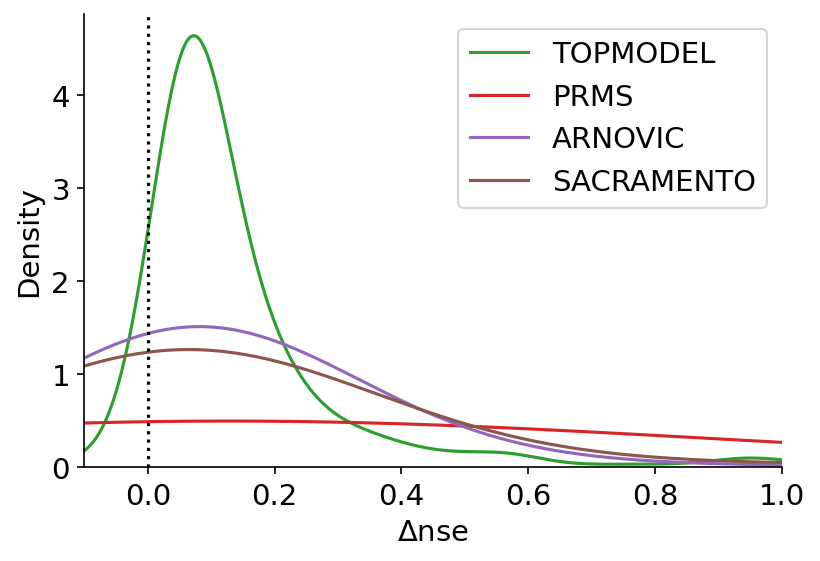

In [28]:
from typing import Tuple

color_lookup = {
    m: sns.color_palette()[2:][ix] for (ix, m) in enumerate(["TOPMODEL", "PRMS", "ARNOVIC", "SACRAMENTO"])
}

def kde_plot_deltas(delta_df: pd.DataFrame, metric: str = "nse", xlim: Tuple[float] = (-1, 1), ax=None):
        kde_kws = {"clip": xlim}
        hist_kws = {"range": xlim, "density": True}
        if ax is None:
            f, ax = plt.subplots()
        [
            sns.distplot(delta_df[c], ax=ax, kde_kws=kde_kws, hist_kws=hist_kws, hist=False, label=c, color=color_lookup[c])
            for c in ["TOPMODEL", "PRMS", "ARNOVIC", "SACRAMENTO"]
        ]
        ax.set_xlim(xlim)
        ax.axvline(0, ls=":", color="k")
        ax.set_xlabel(f"$\Delta${metric}")
        ax.legend()
        sns.despine()


metric = "nse"
kde_plot_deltas(lstm_delta[metric], metric=metric, xlim=(-0.1, 1))

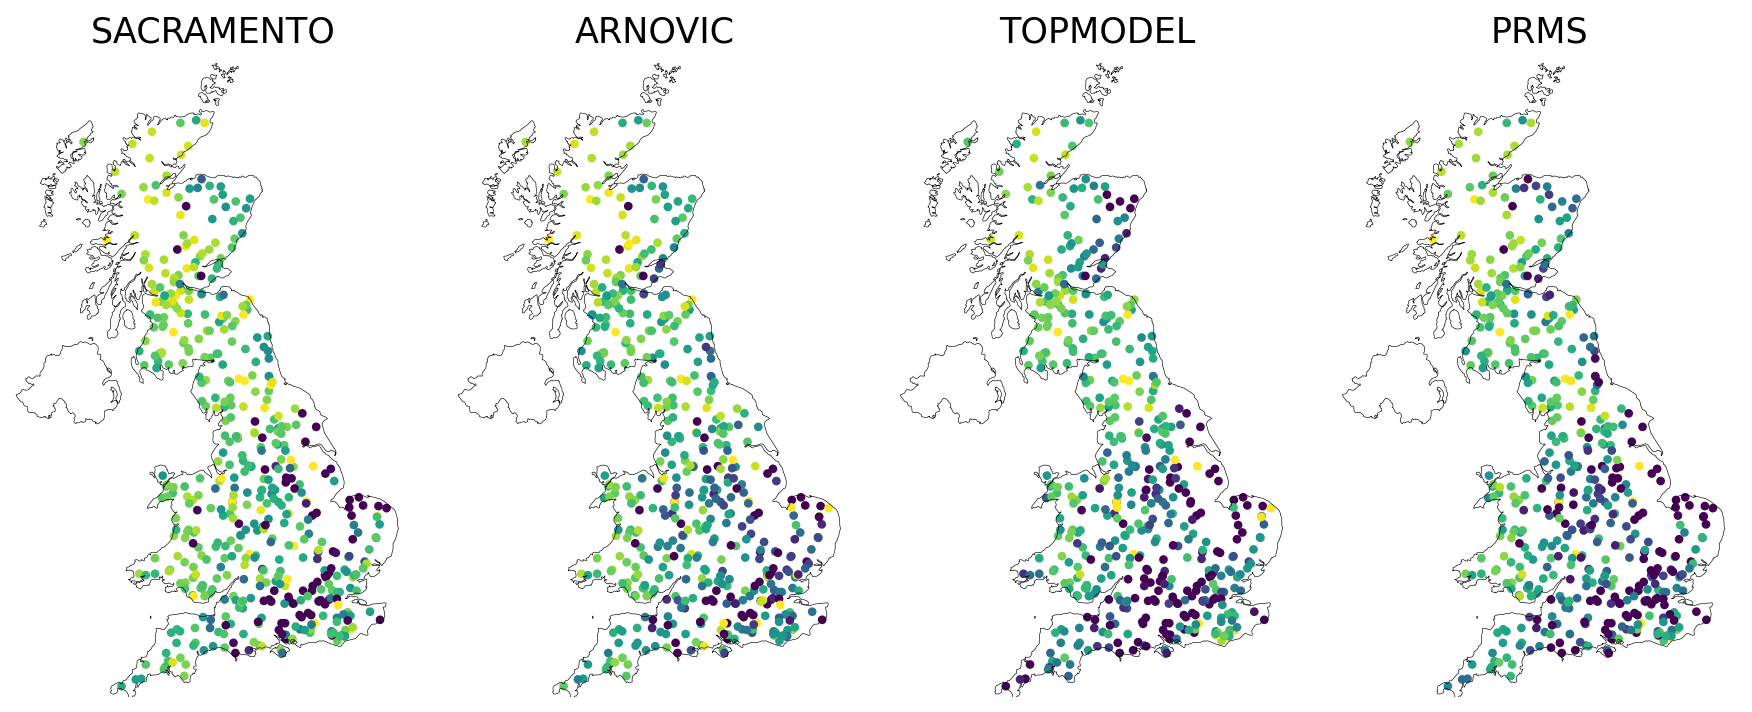

In [29]:
kwargs = {
    "nse": {"vmin": -0.01, "vmax": 0.2, 'cmap': 'viridis_r', "markersize": markersize},
    "correlation": {"vmin": -0, "vmax": 0.2, 'cmap': 'plasma', "markersize": markersize},
    "bias_error": {"vmin": -0.2, "vmax": 0.2, 'cmap': 'RdBu', "markersize": markersize},
    "std_error": {"vmin": -0.2, "vmax": 0.2, 'cmap': 'RdBu', "markersize": markersize},
    "flv": {"vmin": -300, "vmax": 300, 'cmap': 'RdBu', "markersize": markersize},
    "fms": {"vmin": -50, "vmax": 50, 'cmap': 'RdBu', "markersize": markersize},
    "fhv": {"vmin": -20, "vmax": 20, 'cmap': 'RdBu', "markersize": markersize},
}


metric="nse"
plot_geospatial_data_per_metric(
    create_geospatial_data(lstm_delta[metric]), 
    metric=metric, 
    models=["SACRAMENTO", "ARNOVIC", "TOPMODEL", "PRMS"],
    kwargs=kwargs[metric],
    legend=False,
)

# 13 Catchments

In [30]:
catchment_ids = [int(c) for c in ["12002", "15006", "27009", "27034", "27041", "39001", "39081", "43021", "47001", "54001", "54057", "71001", "84013",]]
catchment_names = ["Dee@Park", "Tay@Ballathie", "Ouse@Skelton", "Ure@Kilgram", "Derwent@Buttercrambe", "Thames@Kingston", "Ock@Abingdon", "Avon@Knapp", "Tamar@Gunnislake", "Severn@Bewdley", "Severn@Haw", "Ribble@Samlesbury", "Clyde@Daldowie"]
station_map = dict(zip(catchment_ids, catchment_names))

In [31]:
nse_only = True
process_errors = pd.read_csv(olddata_dir / "RUNOFF/jules_classic.csv")

# Process the CLASSIC NSE values
classic = process_errors.loc[process_errors["Model"] == "Classic", :].drop('Model', axis=1)
classic = classic.rename(columns={"ID": "Station ID"}).set_index("Station ID")
if nse_only:
    classic = classic.drop("Bias", axis=1).rename({"NSE": "CLASSIC"}, axis=1)
else:
    classic.columns = [["CLASSIC" for _ in range(len(classic.columns))], classic.columns]

# Process the JULES NSE values
jules = process_errors.loc[process_errors["Model"] == "Jules", :].drop('Model', axis=1)
jules = jules.rename(columns={"ID": "Station ID"}).set_index("Station ID").drop("Name", axis=1)
if nse_only:
    jules = jules.drop("Bias", axis=1).rename({"NSE": "JULES"}, axis=1)
else:
    jules.columns = [["JULES" for _ in range(len(jules.columns))], jules.columns]

process_errors = pd.concat([classic, jules], axis=1)

In [32]:
nse_all = all_metrics["nse"].drop([c for c in  all_metrics[metric].columns if "climatology" in c or "persistence" in c], axis=1)
nse_all = process_errors.join(nse_all).dropna()

nse_all = nse_all[["Name", "LSTM", "EALSTM"] + [c for c in nse_all.columns if c not in ["Name", "LSTM", "EALSTM"]]]

In [33]:
print(nse_all.to_latex(float_format="%.2f"))

\begin{tabular}{llrrrrrrrr}
\toprule
{} &                        Name &  LSTM &  EALSTM &  CLASSIC &  JULES &  TOPMODEL &  ARNOVIC &  PRMS &  SACRAMENTO \\
Station ID &                             &       &         &          &        &           &          &       &             \\
\midrule
12002      &                Dee at Park  &  0.76 &    0.76 &     0.55 &   0.51 &      0.65 &     0.71 &  0.68 &        0.71 \\
15006      &           Tay at Ballathie  &  0.90 &    0.90 &     0.46 &   0.64 &      0.79 &     0.88 &  0.86 &        0.88 \\
27009      &            Ouse at Skelton  &  0.94 &    0.91 &     0.80 &   0.69 &      0.86 &     0.89 &  0.88 &        0.91 \\
27034      &      Ure at Kilgram Bridge  &  0.85 &    0.85 &     0.78 &   0.75 &      0.84 &     0.84 &  0.85 &        0.85 \\
27041      &    Derwent at Buttercrambe  &  0.92 &    0.80 &     0.65 &   0.49 &      0.77 &     0.78 &  0.82 &        0.87 \\
39001      &         Thames at Kingston  &  0.96 &    0.94 &     0.81 &  

# Budyko Analysis

In [34]:
from scripts.drafts.plots import plot_budyko_curve, calculate_curve_params, curve
import matplotlib.cm as cm
import matplotlib.colors as colors

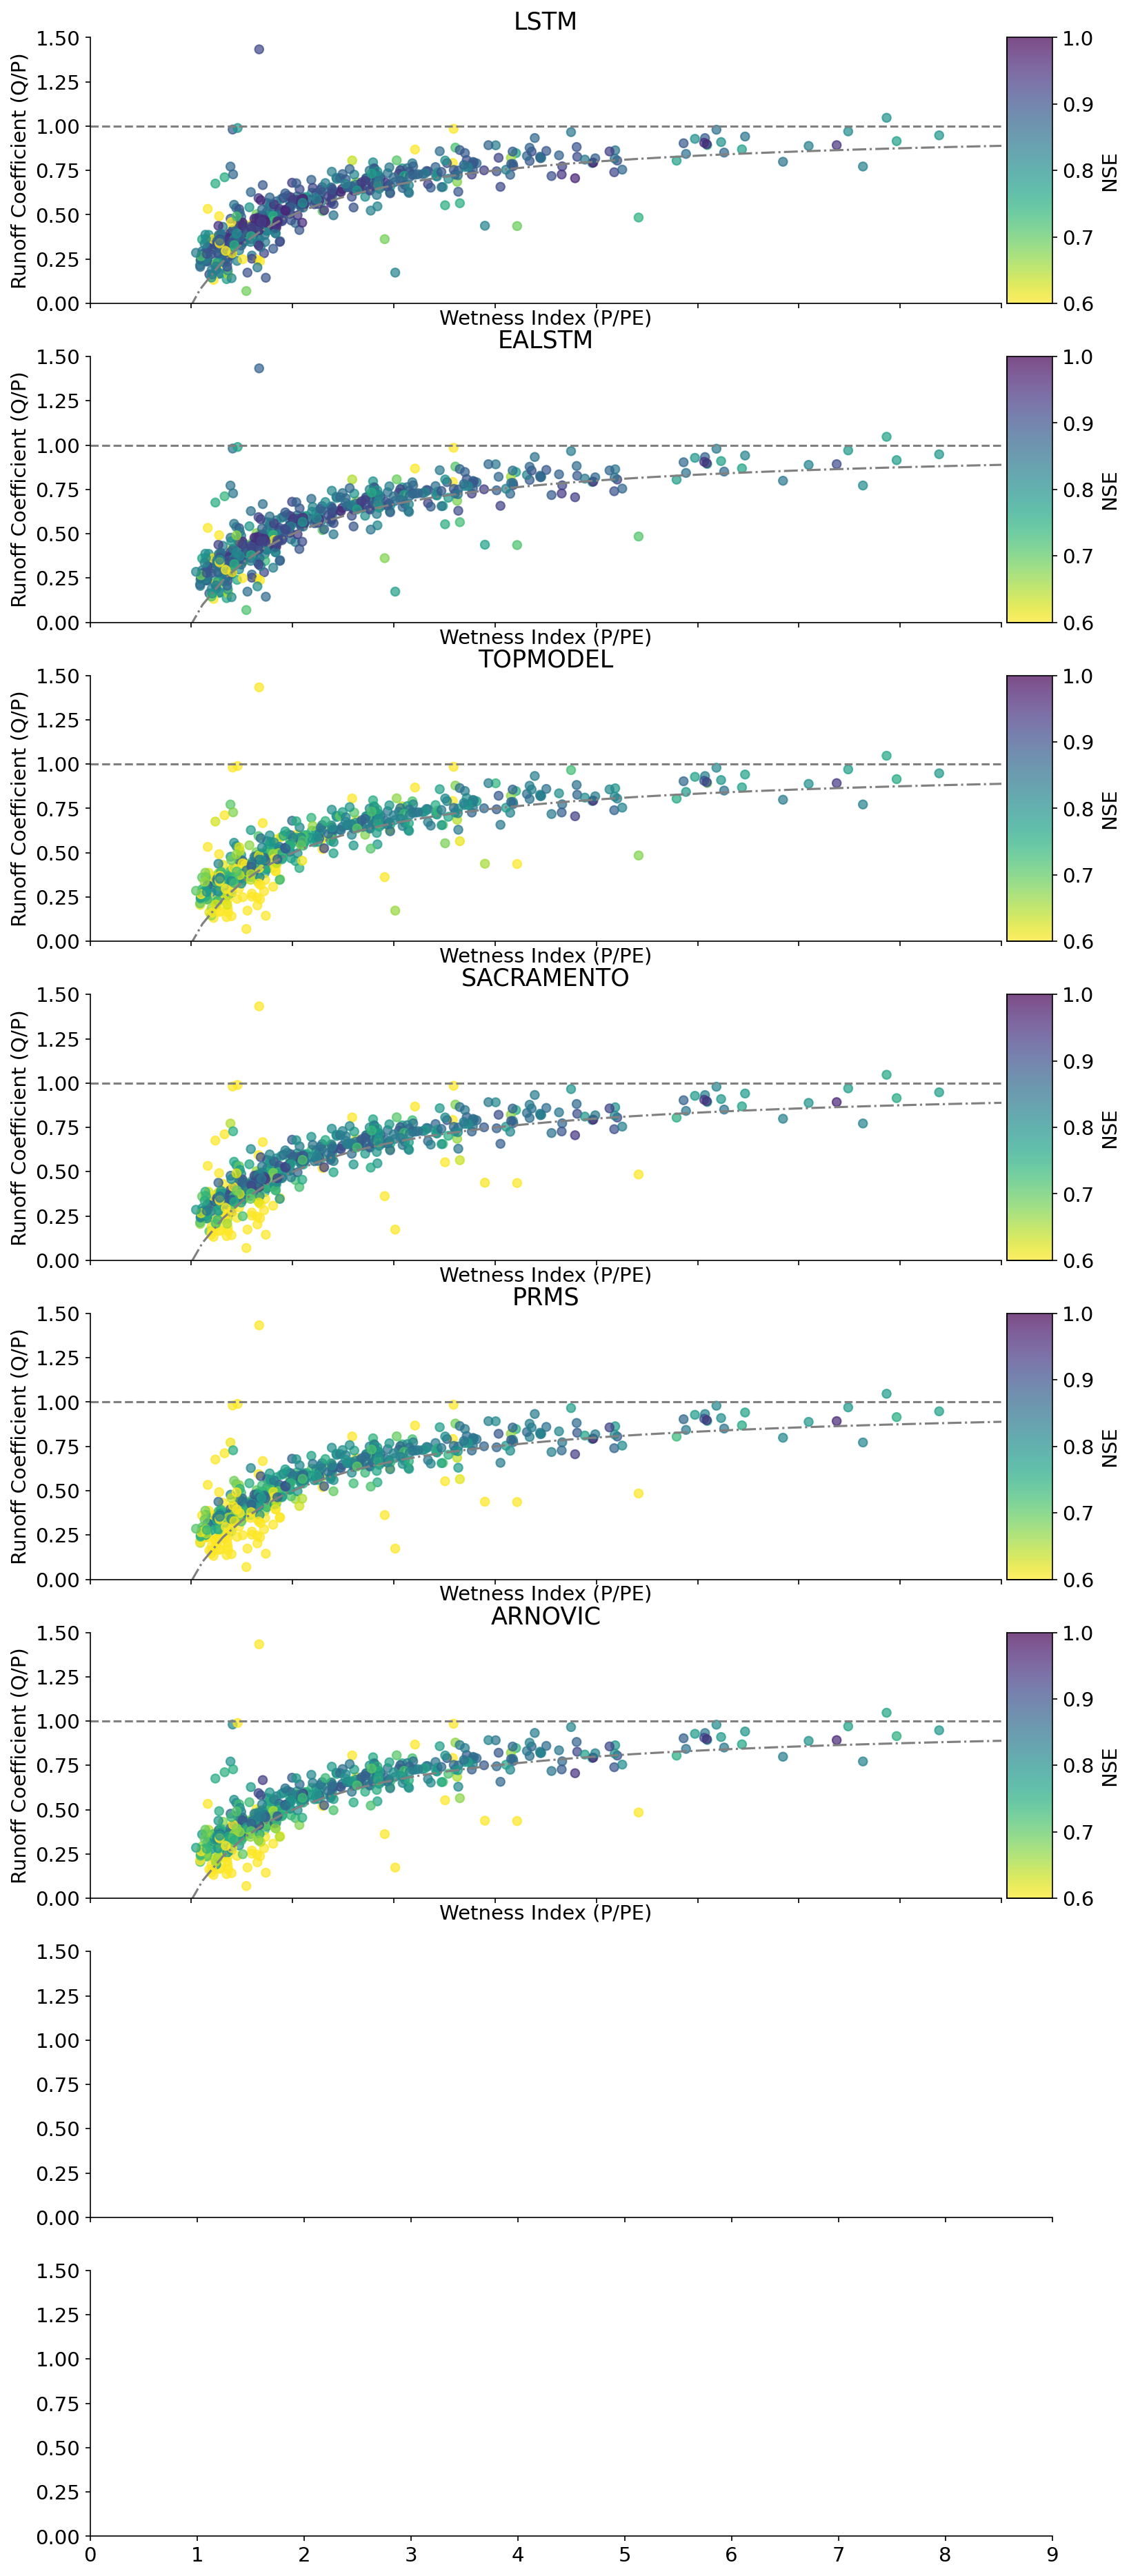

In [35]:
scale = 1

metrics = ["nse", "correlation", "bias_error", "std_error", "flv", "fms", "fhv"]
# metrics = ["nse", "correlation"]

n_subplots = len(["LSTM", "EALSTM", "TOPMODEL", "SACRAMENTO", "PRMS", "ARNOVIC"])
n_subplots = 8
f, axs = plt.subplots(n_subplots, 1, sharex=True, sharey=True, figsize=(12*scale, 4*scale*n_subplots))

kwargs_lookup = {
    "nse": {"vmin": "0.8", "vmax": "1", "cmap": "viridis_r", "alpha": 0.7},
    "correlation": {"vmin": "0.85", "vmax": "1", "cmap": "viridis_r", "alpha": 0.7},
    "bias_error": {"vmin": "-0.25", "vmax": "0.25", "cmap": "RdBu", "alpha": 0.7},
    "std_error": {"vmin": "-0.25", "vmax": "0.25", "cmap": "RdBu", "alpha": 0.7},
    "flv": {"vmin": "-100", "vmax": "100", "cmap": "RdBu", "alpha": 0.7},
    "fms": {"vmin": "-20", "vmax": "20", "cmap": "RdBu", "alpha": 0.7},
    "fhv": {"vmin": "-20", "vmax": "20", "cmap": "RdBu", "alpha": 0.7},
}


# model = "ARNOVIC"
# color_var = published.set_index("station_id").loc[all_metrics["nse"].index, "NSE_TOPMODEL"]
# color_var = all_metrics["nse"]["TOPMODEL"]

metric = "nse"
mean_ds = ds.mean(dim="time").sel(station_id=all_metrics["nse"]["LSTM"].index)

for ix, model in enumerate(["LSTM", "EALSTM", "TOPMODEL", "SACRAMENTO", "PRMS", "ARNOVIC"]):
    kwargs_lookup = {"nse": {"vmin": "0.6", "vmax": "1", "cmap": "viridis_r", "alpha": 0.7}}
    ax = axs[ix]
    plot_budyko_curve(
        ds=mean_ds,
        color_var=all_metrics[metric][model],  #color_var,  # all_metrics[metric][model],
        color_label=f"{metric.upper()}",
        vmin=kwargs_lookup[metric].pop("vmin"),  # ,
        vmax=kwargs_lookup[metric].pop("vmax"),  # ,
        scatter_kwargs=kwargs_lookup[metric],
        annotate=False,
        ax=ax
    )
    ax.set_title(model)


### Get the "physical" catchments

In [36]:
from scripts.drafts.plots import calculate_curve_params, curve

# get_points_below_curve ()
x, y = calculate_curve_params(ds=ds.mean(dim="time"))

ref_y = curve(x)
# below line means that y_obs < y_ref
(y < ref_y)

stations_where_remaining_h2o_lt_pet = (y < ref_y).rename("unphysical")

nse_physical = all_metrics["nse"].join(stations_where_remaining_h2o_lt_pet.to_dataframe()).copy()
nse_physical.head()

TOPMODEL   ARNOVIC      PRMS  SACRAMENTO      LSTM    EALSTM  \
station_id                                                                 
1001        0.754303  0.766521  0.786218    0.805396  0.803916  0.802358   
2001        0.655162  0.685077  0.686722    0.699972  0.704050  0.709909   
2002        0.691850  0.681148  0.683937    0.697952  0.702446  0.691165   
3003        0.806642  0.799981  0.793153    0.805893  0.815074  0.784192   
4001        0.724438  0.818019  0.777022    0.792738  0.842063  0.832938   

            unphysical  
station_id              
1001             False  
2001             False  
2002             False  
3003              True  
4001             False

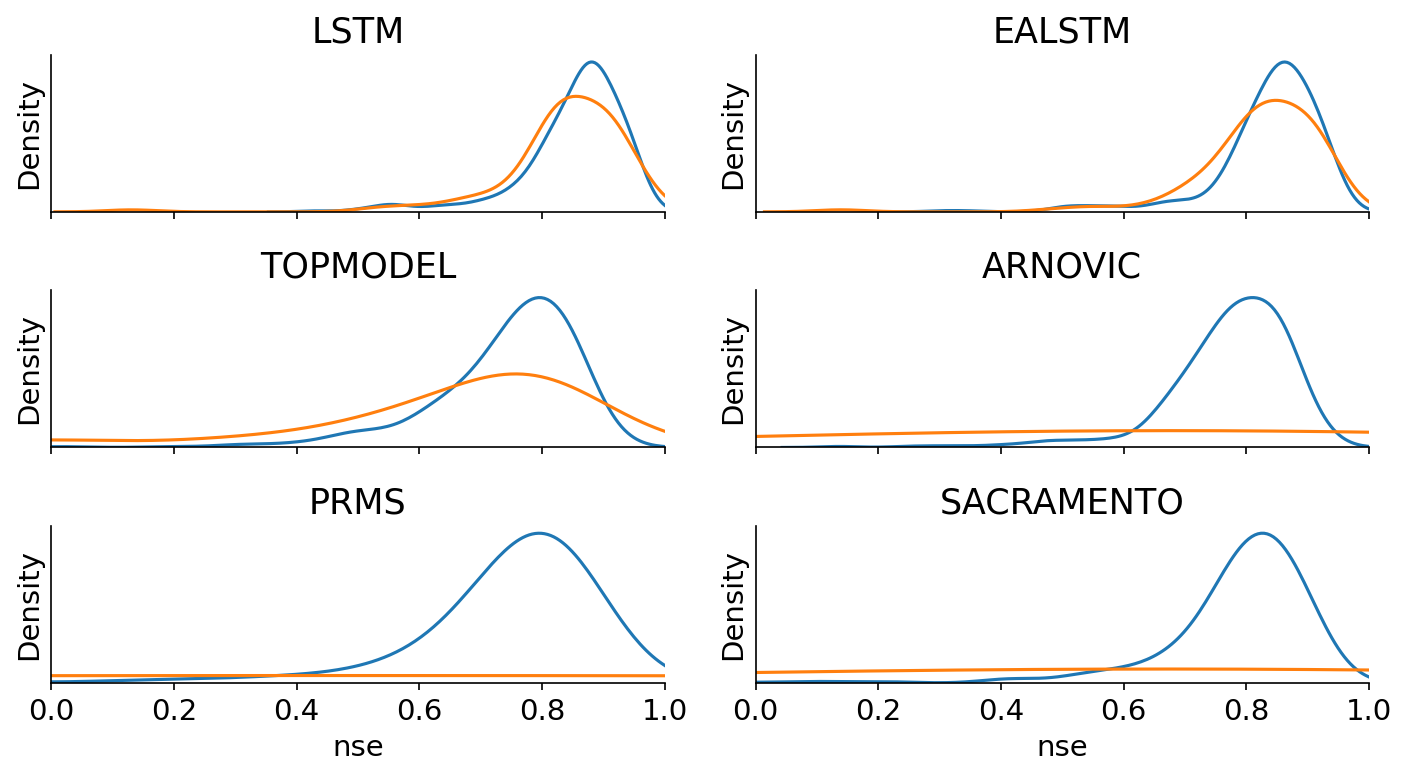

In [39]:
models = ["LSTM", "EALSTM", "TOPMODEL", "ARNOVIC", "PRMS", "SACRAMENTO",]

scale = 1.2
subplot_size = (3, 2)
f, axs = plt.subplots(subplot_size[0], subplot_size[1], sharex=True, figsize=(4*scale* subplot_size[1], 1.5*scale*subplot_size[0]))
clip = (0, 1)
for ix, model in enumerate(models):
    ax = axs[np.unravel_index(ix, subplot_size)]
    sns.distplot(nse_physical.loc[~nse_physical["unphysical"], model].rename("nse"), ax=ax, kde_kws=dict(clip=clip), hist=False, label="Physically Realistic")
    sns.distplot(nse_physical.loc[nse_physical["unphysical"], model].rename("nse"), ax=ax, kde_kws=dict(clip=clip), hist=False, label="Excess Water")
#     sns.kdeplot(nse_physical.loc[nse_physical["unphysical"], model].rename("nse"), cumulative=False, clip=clip, ax=ax, label="Excess Water")
    ax.set_yticklabels([""])
    ax.set_yticks([])
    ax.set_xlim(clip)
    ax.set_title(model)
    sns.despine()
    if ix != 0:
        if ax.get_legend() is not None:
            ax.get_legend().remove()


plt.tight_layout()

# Regional Matrix

In [40]:
[d for d in (olddata_dir / "RUNOFF/gis_data_Tommy").glob("*/*.shp")]

[PosixPath('/datadrive/olddata/RUNOFF/gis_data_Tommy/Aquifers/Uk_HydroGeology_Simplified.shp'),
 PosixPath('/datadrive/olddata/RUNOFF/gis_data_Tommy/UK_Lakes/UK_Lakes.shp'),
 PosixPath('/datadrive/olddata/RUNOFF/gis_data_Tommy/UK_hydroclimate_regions_Harrigan_et_al_2018/UK_Hydro_Regions_ESP_HESS.shp')]

In [42]:
lakes = gpd.read_file(olddata_dir / "RUNOFF/gis_data_Tommy" / "UK_Lakes/UK_Lakes.shp").to_crs(epsg=4326)
hydro_regions = gpd.read_file(olddata_dir / "RUNOFF/gis_data_Tommy" / "UK_hydroclimate_regions_Harrigan_et_al_2018/UK_Hydro_Regions_ESP_HESS.shp").to_crs(epsg=4326)
hydro_regions = hydro_regions.loc[~np.isin(hydro_regions["NAME"], ["Northern Ireland", "Republic of Ireland"])]
aquifers = gpd.read_file(olddata_dir / "RUNOFF/gis_data_Tommy" / "Aquifers/Uk_HydroGeology_Simplified.shp").to_crs(epsg=4326)

In [43]:
region_abbrs = {
    'Western Scotland': "WS",
    'Eastern Scotland': "ES",
    'North-east England': "NEE",
    'Severn-Trent': "ST",
    'Anglian': "ANG",
    'Southern England': "SE",
    'South-west England & South Wales': "SWESW",
    'North-west England & North Wales (NWENW)': "NWENW",
}

def get_region_station_within(stations: gpd.GeoDataFrame, hydro_regions: gpd.GeoDataFrame):
    # find the region that a station belongs WITHIN
    # create a list of strings/nans for each station 
    region_dict = {}
    for region, geom in zip(hydro_regions["NAME"], hydro_regions["geometry"]):
        isin_region = ([p.within(geom) for p in stations])
        region_dict[region] = [(region if item else np.nan) for item in isin_region]

    region_cols = pd.DataFrame(region_dict)

    # copy non-null values from the right column into the left and select left
    # https://stackoverflow.com/a/49908660
    regions_list = (region_cols.bfill(axis=1).iloc[:, 0]).rename("region")
    regions_list.index = points.index

    return regions_list

In [44]:
regions_list = get_region_station_within(points, hydro_regions)
all_points = gpd.GeoDataFrame(points).join(names).join(regions_list)
hydro_regions

RAIN  LTA                                      NAME  RP_SCORE  DISP_LABEL  \
0   966  116                        North-east England       6.0           1   
1   778  102                              Severn-Trent       2.0           1   
2   725  104                          Southern England       2.0           1   
3  1328  113  North-west England & North Wales (NWENW)       6.0           1   
5  1253  132                          Eastern Scotland      95.0           1   
6  1332  110          South-west England & South Wales       5.0           1   
7   595   99                                   Anglian      -2.0           1   
8     0    0                          Western Scotland       0.0           0   

     SHAPE_AREA     SHAPE_LEN SHORT_NAME  \
0  22612.294923  5.542185e+05        NEE   
1  21480.685007  1.200153e+06         ST   
2  33907.705000  7.926037e+05         SE   
3  21496.639256  1.213441e+06      NWENW   
5  28146.072403  6.444073e+05         ES   
6  24909.380988  1.195516e+06      SWESW   
7  26762.155046  1.636992e+06        ANG   
8  47845.444560  0.000000e+00         WS   

                                            geometry  
0  POLYGON ((-2.03827 55.81346, -2.02709 55.79999...  
1  POLYGON ((-0.65191 53.69944, -0.65525 53.68959...  
2  MULTIPOLYGON (((-1.28967 50.75783, -1.28564 50...  
3  MULTIPOLYGON (((-4.42643 53.43250, -4.42021 53...  
5  POLYGON ((-3.33302 57.72354, -3.30939 57.72019...  
6  MULTIPOLYGON (((-3.77165 51.23126, -3.74422 51...  
7  POLYGON ((0.20676 51.49097, 0.21435 51.49892, ...  
8  MULTIPOLYGON (((-5.26224 55.71892, -5.20189 55...

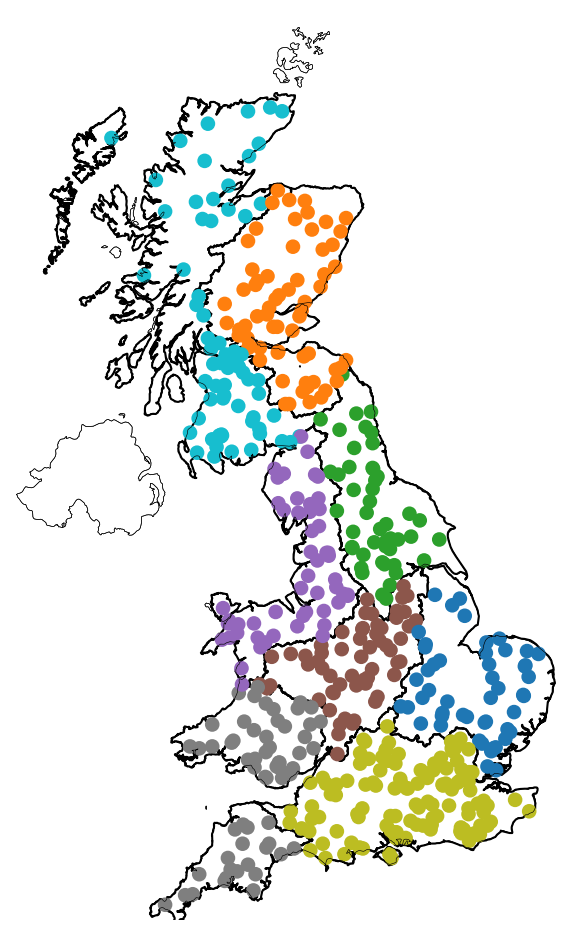

In [45]:
TEXT = False

region_gdf = create_geospatial_data(regions_list.to_frame())
f, ax = plt.subplots(figsize=(5, 8))
_plot_geospatial(hydro_regions, "SHORT_NAME", ax=ax, kwargs=dict(facecolor='none', edgecolor='black'), legend=False);  # facecolor='none',
_plot_geospatial(region_gdf.loc[(all_preds.station_id.values)], "region", ax=ax, legend=False);  # facecolor='none',

if TEXT:
    hydro_regions['coords'] = hydro_regions['geometry'].apply(lambda x: x.representative_point().coords[:])
    hydro_regions['coords'] = [coords[0] for coords in hydro_regions['coords']]
    for idx, row in hydro_regions.iterrows():
        plt.annotate(s=row['SHORT_NAME'], xy=row['coords'],
                     horizontalalignment='center', size=10)


In [46]:
from typing import List, Dict, Tuple

def get_region_and_UK_wide_metric(df: pd.DataFrame, agg: str = "median", models: List[str] = ['TOPMODEL', 'ARNOVIC', 'PRMS', 'SACRAMENTO', 'EALSTM', 'LSTM',]) -> pd.DataFrame:
    assert all(np.isin(["region", "LSTM"], df.columns))
    if agg == "median":
        # Median in each region
        med_region = df.groupby("region").median()[models]
        med_region.values.shape

        # Append Whole of UK Median (as a region)
        med_values = np.vstack([df.median()[models].values, med_region.values])

    elif agg == "mean":
        # Mean in each region
        med_region = df.groupby("region").mean()[models]
        med_region.values.shape

        # Append Whole of UK Median (as a region)
        med_values = np.vstack([df.mean()[models].values, med_region.values])
    else:
        assert False
        
    region = ["UK"] + [region_abbrs[l] for l in med_region.index.values]
    columns = med_region.columns
    med_region = pd.DataFrame(med_values, columns=columns, index=region)
    return med_region


def plot_matrix_of_each_region_and_model(
    df: pd.DataFrame,
    agg: str = "median",
    models: List[str] =  ['TOPMODEL', 'ARNOVIC', 'PRMS', 'SACRAMENTO', 'EALSTM', 'LSTM',],
    kwargs: Dict = {"cmap": "blues"}
):
    assert all(np.isin(["region", "region_abbr"], df.columns)), f"Expect [region region_abbr] to be in {df.columns}"
    assert agg in ["mean", "median"], "Expect agg to be one of median, mean"
    med_region = get_region_and_UK_wide_metric(df, agg=agg, models=models)

    # https://stackoverflow.com/a/40890587
    fig, ax = plt.subplots(figsize=(12, 8))

    intersection_matrix = med_region.values

    ax.imshow(intersection_matrix.T, **kwargs)

    for region_ix in range(intersection_matrix.shape[0]):
        for model_ix in range(intersection_matrix.shape[1]):
            c = intersection_matrix[region_ix, model_ix]
            ax.text(region_ix, model_ix, f"{c:.2f}", va='center', ha='center')

    ax.set_ylabel("Model")
    ax.set_xlabel("Region")
    ax.set_xticklabels([''] + list(med_region.index))
    ax.set_yticklabels([''] + list(med_region.columns))
    
    return ax

Text(0.5, 1.0, 'Median UK and Regional NSE')

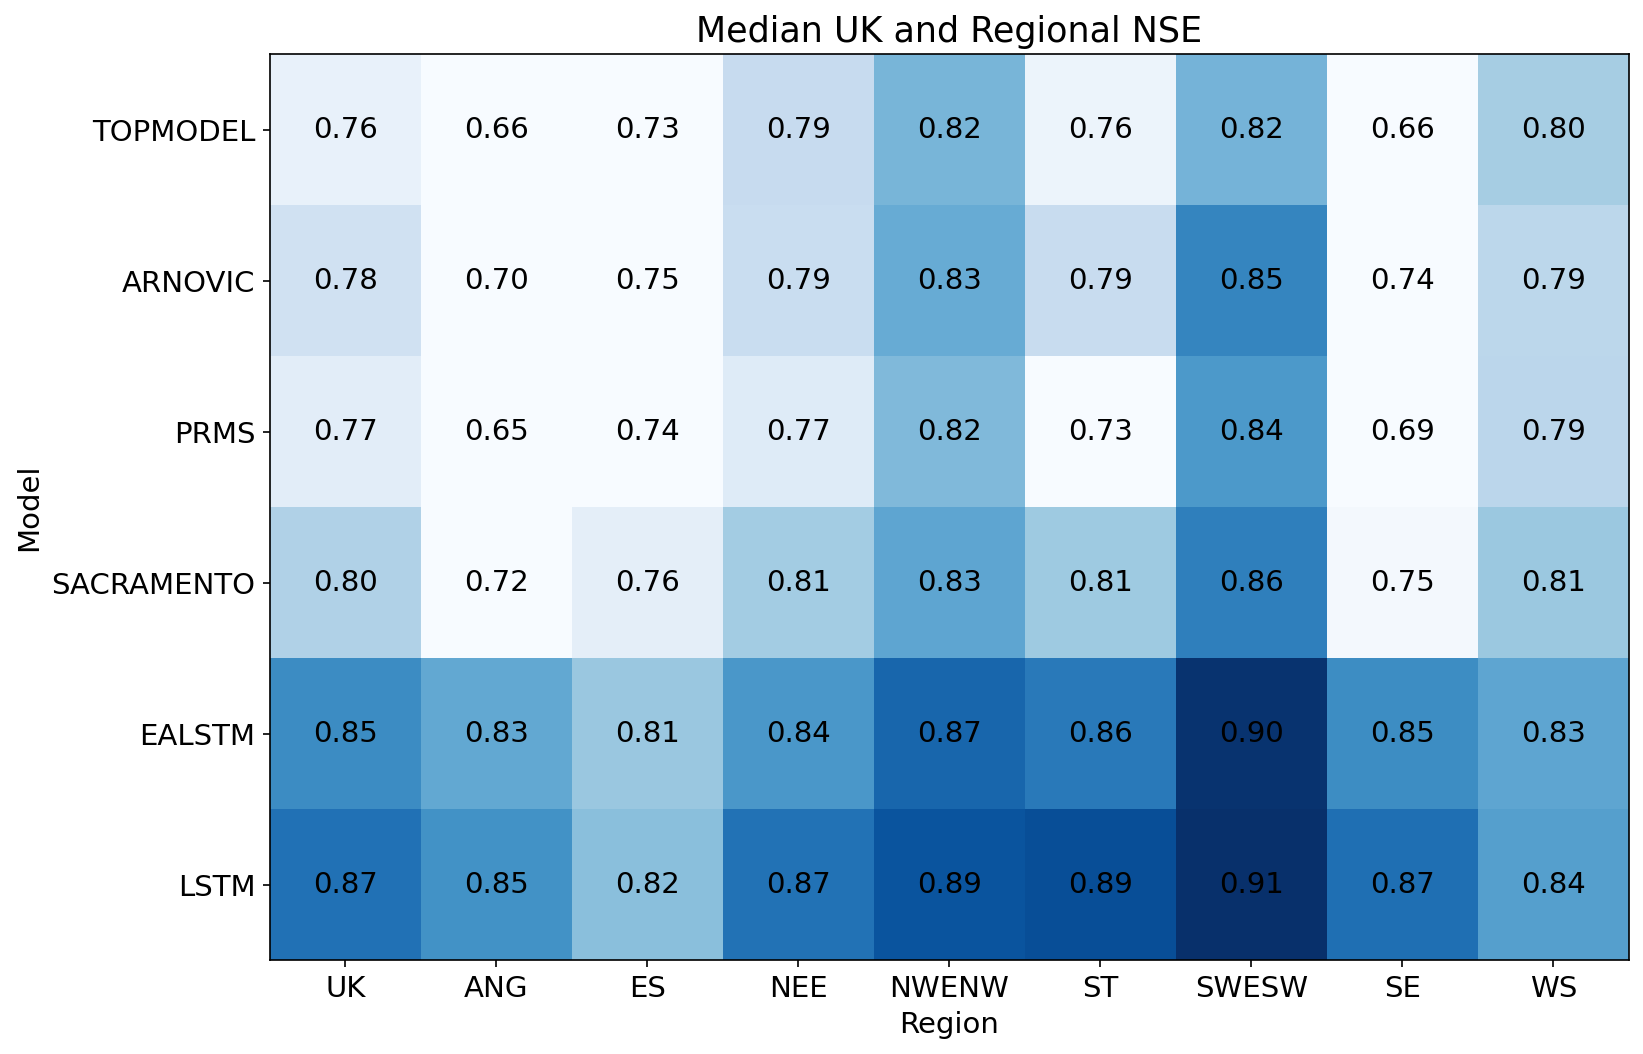

In [47]:
skill_score = False
metric = "nse"

vmin = 0.75
vmax = None
cmap = "Blues"
agg = "median"

# select table of metrics (skill-score or raw)
if skill_score:
    df = skill_scores["climatology_doy"][metric].join(regions_list)
else:
    df = all_metrics[metric].join(regions_list)

df["region_abbr"] = df["region"].map(region_abbrs)

plot_matrix_of_each_region_and_model(df, agg=agg, kwargs={"vmin": vmin, "vmax": vmax, "cmap": cmap})
ax = plt.gca()
ax.set_title(f"{agg.capitalize()} UK and Regional {metric.upper()}{'SS' if skill_score else ''}")

# Get the stations with negative ∆NSE

In [48]:
metric = "nse"
worse_basins = {}
models = ["TOPMODEL", "PRMS", "SACRAMENTO", "ARNOVIC"]
for ix, model in enumerate(models):
    delta_df = lstm_delta[metric]
    worse_basins[model] = delta_df.loc[delta_df[model] < 0].index
    

flatten = lambda t: [item for sublist in t for item in sublist]
all_worse_sids = set(flatten(worse_basins.values()))

In [49]:
models = ["TOPMODEL", "SACRAMENTO", "PRMS", "ARNOVIC"]

order_ = all_metrics["nse"].loc[[int(sid) for sid in all_worse_sids], models + ["EALSTM", "LSTM"]] # .drop("Name", axis=1)
order_ = (order_["LSTM"] - order_.drop("LSTM", axis=1).T).min().sort_values()

print(f"Median Absolute Delta NSE for the Stations where DeltaNSE < 0: {order_.abs().median():.02f}")
print(order_.index)

Median Absolute Delta NSE for the Stations where DeltaNSE < 0: 0.02
Int64Index([41004, 34008, 54052, 41019, 33054, 40018, 28050, 30005, 54015,
            32006, 54060, 29005, 42016, 27035, 21023,  5003, 79003, 40004,
            84016, 58009, 21016, 34004, 92001, 15007, 68020, 15012, 25020,
            37009, 25012, 39105, 80004, 25003, 41001, 34005, 27034, 43021,
             6007, 84017, 28012, 16001,  8013, 39005, 21013, 15014,  1001,
            19020],
           dtype='int64', name='station_id')


In [50]:
worse_nse = all_metrics["nse"].loc[[int(sid) for sid in all_worse_sids]]
worse_df = worse_nse[models + ["EALSTM", "LSTM"]]
worse_df = worse_df.stack().reset_index(-1).rename({"level_1": "model", 0: "nse"}, axis=1)

names = static[["gauge_name"]].to_dataframe()
names = names.loc[np.isin(names.index, worse_df.index)]
worse_df = names.join(worse_df).rename({"gauge_name": "Name"}, axis=1).loc[[int(sid) for sid in order_.index]]

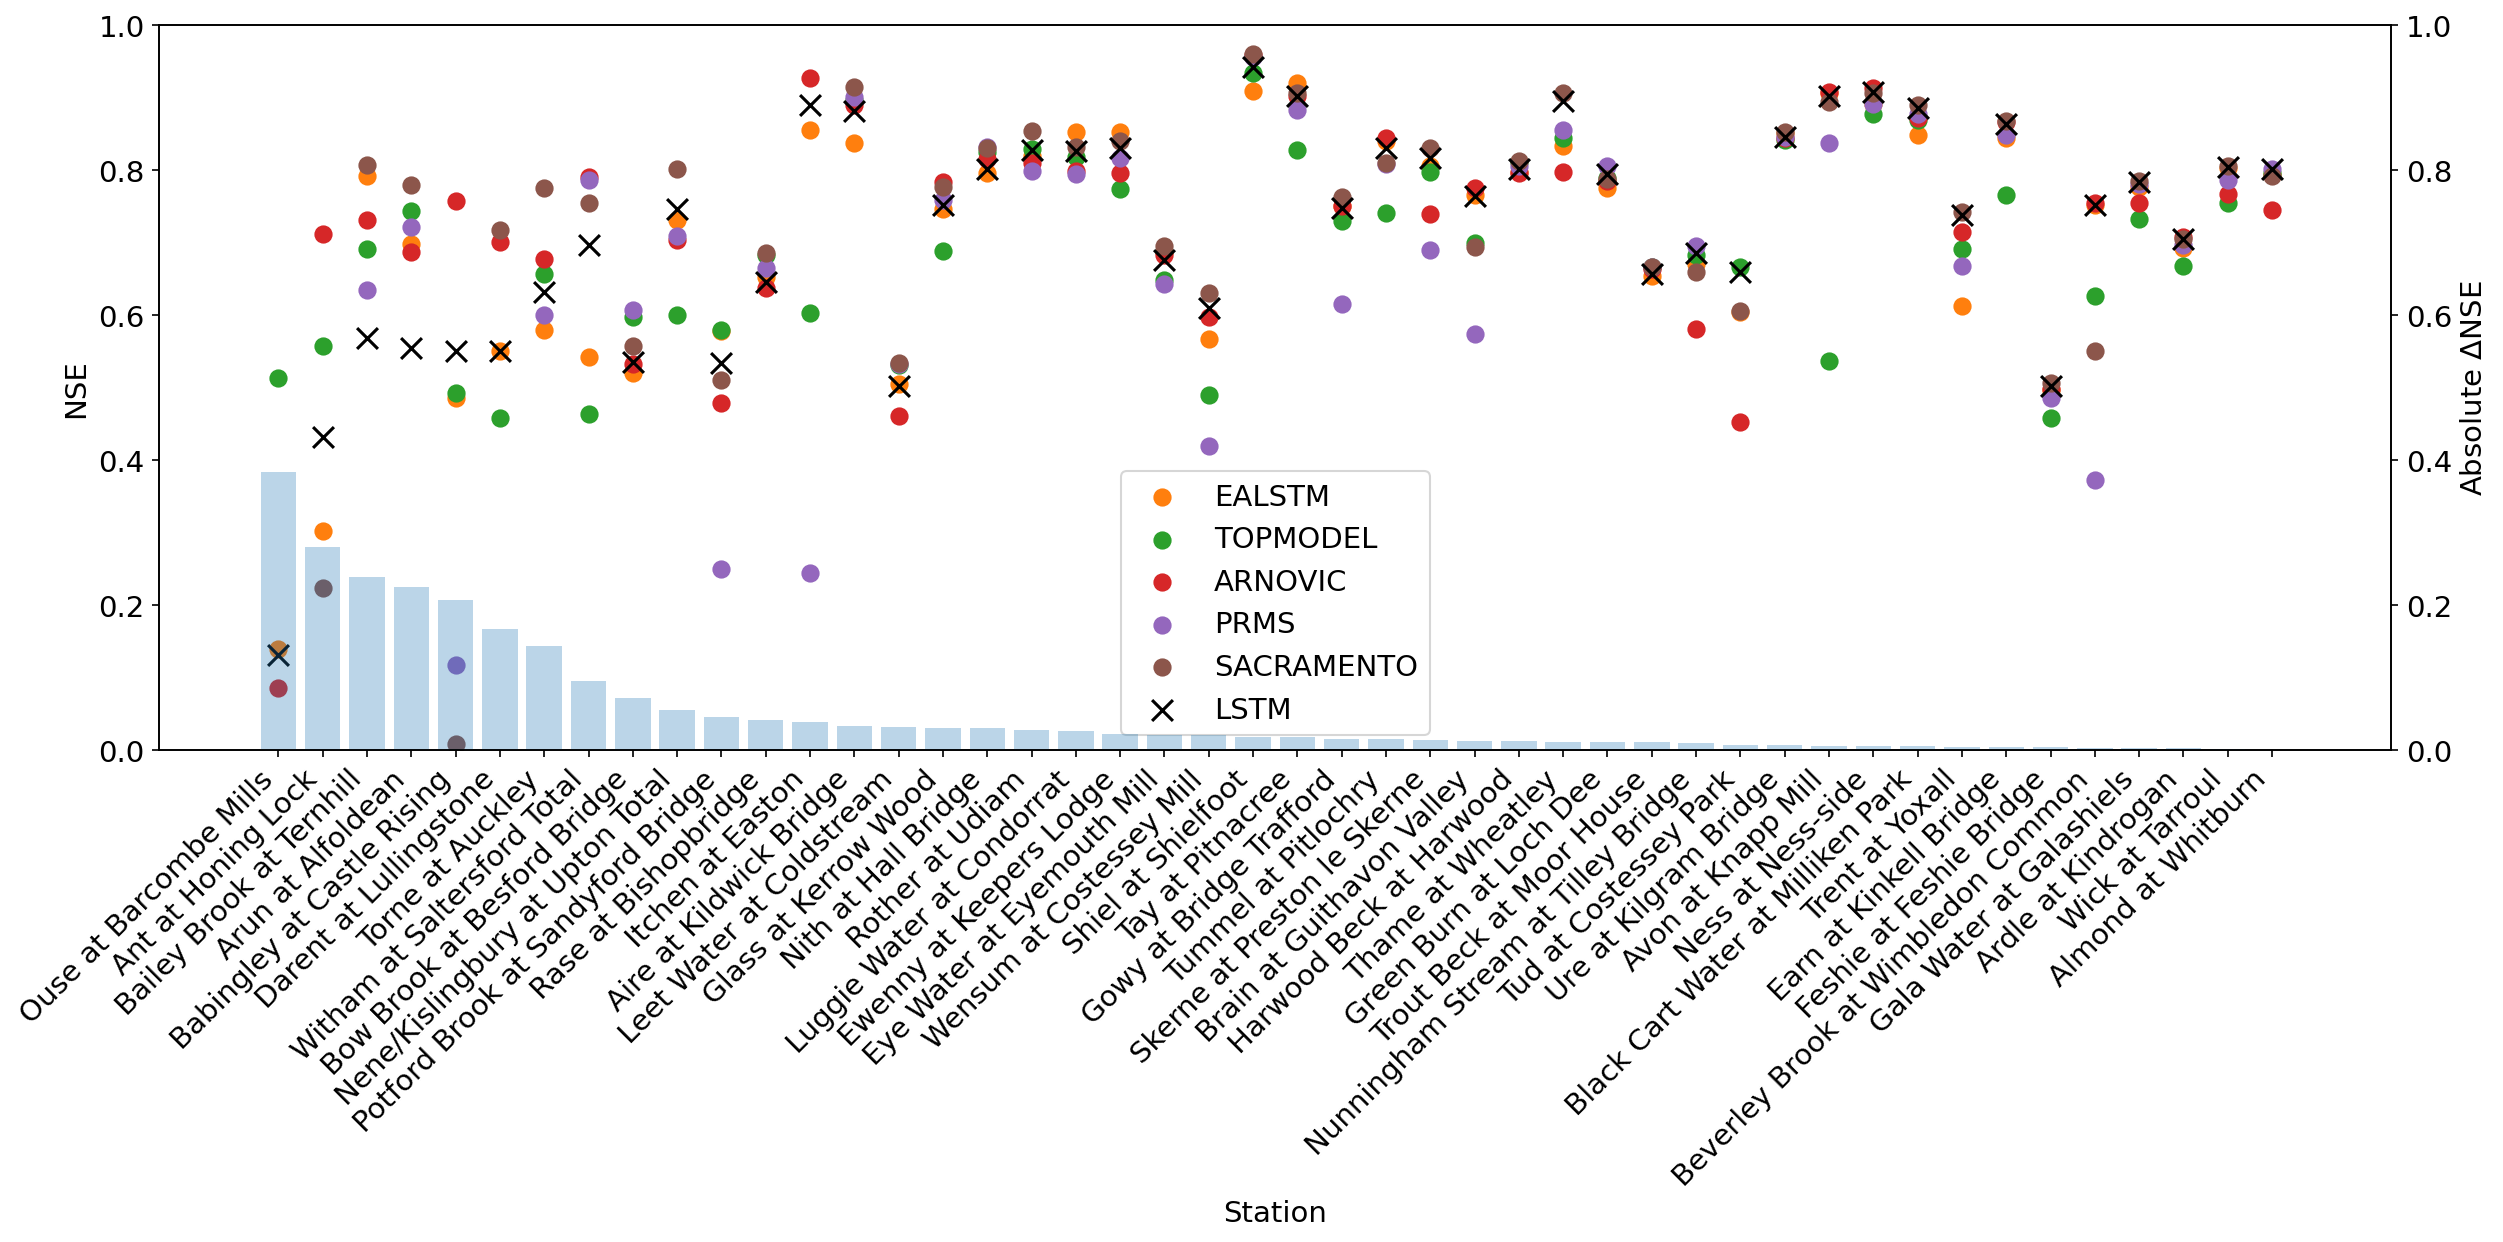

In [51]:
scale = 1.6

# plot_data = worse_df 
# plot_data["nse"] = plot_data["nse"] + np.random.normal(0, 0.01, len(plot_data["nse"]))
# TOPMODEL (green), VIC (red), PRMS (purple), Sacramento
model_order = ["LSTM", "EALSTM", "TOPMODEL", "ARNOVIC", "PRMS", "SACRAMENTO"]
abs_ = True
f, ax = plt.subplots(figsize=(12*scale, 4*scale))

# PLOT THE CONCEPTUAL MODEL NSE PERFORMANCE
colors = sns.color_palette()[1: len(model_order)]
for ix, model in enumerate(model_order[1:]):
    plot_data = worse_df.loc[worse_df["model"] == model]
    ax.scatter(plot_data["Name"], plot_data["nse"], color=colors[ix], s=60, label=model)

# PLOT THE LSTM MODEL NSE PERFORMANCE
plot_data = worse_df.loc[worse_df["model"] == "LSTM"]
ax.scatter(plot_data["Name"], plot_data["nse"], color="k", marker="x", s=100, label="LSTM")
plt.xticks(rotation=45, ha="right")

ax.set_xlabel("Station")
ax.set_ylabel("NSE")
ax.set_ylim(0, 1)
ax.legend()

# Plot the raw difference
ax2 = ax.twinx()
if abs_:
    ax2.bar(plot_data.drop_duplicates()["Name"], abs(order_), alpha=0.3)
    ax2.set_ylim(0, 1)
    ax2.set_ylabel("Absolute $\Delta$NSE")
else:
    ax2.bar(plot_data.drop_duplicates()["Name"], order_, alpha=0.3)
    ax2.set_ylim(-0.7, 0)
    ax2.set_ylabel("$\Delta$NSE")
# sns.despine()

In [52]:
print(f"{len(worse_nse)} {100*(len(worse_nse) / 518):.2f}% of stations worse than any conceptual model")

46 8.88% of stations worse than any conceptual model


# Do static features correlate with performance?

In [53]:
static_df = static.sel(station_id=all_preds.station_id).to_dataframe()
# get only the non-nan numeric attributes
static_df = static_df.loc[:, static_df.dtypes == "float64"].dropna(axis=1)

In [54]:
from scipy.stats import spearmanr, kendalltau


def calculate_correlation_with_static_features(metric_values: pd.Series, static_df: pd.DataFrame, method: str = "spearman") -> pd.DataFrame:
    func_lookup = {
        "kendall": kendalltau,
        "spearman": spearmanr,
    }
    out = defaultdict(list)
    
    static_df = static_df.loc[metric_values.index]
    assert all(static_df.index == metric_values.index)
    
    for feature in static_df.columns:
        result = func_lookup[method](metric_values, static_df[feature])
        out["correlation"].append(result.correlation)
        out["pvalue"].append(result.pvalue)
        out["variable"].append(feature)

    rank_correlations = pd.DataFrame(out)
    return rank_correlations

metric = all_errors["LSTM"]["nse"]
rank_correlations = calculate_correlation_with_static_features(metric, static_df, method="kendall")

# subset based on P Value < 0.01
significant = rank_correlations.loc[(rank_correlations.pvalue < 0.01) & (abs(rank_correlations.correlation) > 0.1)]

In [55]:
from typing import Optional, List, Dict, Tuple, DefaultDict
import pandas as pd
import numpy as np


def rank_correlation_static_metric(metric_df: pd.DataFrame, static: Optional[xr.Dataset] = None, method: str = "spearman"):
    # calculate correlations for EACH column in metric_df
    if static is None:
        static = xr.open_dataset("/cats/datstore/data/RUNOFF/")
    
    static_df = static.to_dataframe()
    stations = metric_df.index
    # numerical non nan rows of matching stations
    static_df = static_df.loc[stations, (static_df.dtypes == "float64")]
    static_df = static_df.loc[:, ~(static_df.isnull().mean(axis=0) > 0)]
    
    # calculate rank correlation between all static features and performance metric
    all_spearmans: Dict[str, pd.DataFrame] = {}
    for model in metric_df.columns:
        # run the correlation
        spear_df = calculate_correlation_with_static_features(metric_df[model], static_df, method=method)
        spear_df["model"] = model
        all_spearmans[model] = spear_df
        
    return all_spearmans

In [56]:
def subset_significant_features(corrs: pd.DataFrame, pvalue: float = 0.01, coefficient_threshold: Optional[float] = None):
    corrs = corrs.loc[(corrs.pvalue < pvalue)]
    if coefficient_threshold is not None:
        corrs = corrs.loc[(abs(corrs.correlation) > coefficient_threshold)]
    
    return corrs.reindex(corrs.correlation.abs().sort_values(ascending=False).index)

## Correlation with raw metrics

In [57]:
from src.preprocess._camels_static_metadata import groupings
hydro_static = static_df[[c for c in groupings["hydrologic_attributes"] if c!= "gauge_id"]]

In [58]:
groupings.keys()

dict_keys(['climatic_attributes', 'humaninfluence_attributes', 'hydrogeology_attributes', 'hydrologic_attributes', 'hydrometry_attributes', 'landcover_attributes', 'soil_attributes', 'topographic_attributes'])

In [59]:
# corrs.loc[(corrs.pvalue < 0.01) & (abs(corrs.correlation) > 0.2)].reindex(significant.correlation.abs().sort_values(ascending=False).index)
metric = "nse"
important_features = [
    # topography
    "dpsbar",
    "elev_mean",
    "elev_min",
    "elev_max",
    # Hydrologic Attributes
    "q_mean",
    "runoff_ratio",
    "slope_fdc",
    "baseflow_index",
    "Q5",
    "Q95",
    #  climatic indices
    "p_mean",
    "pet_mean",
    "aridity",
    "frac_snow",
    # landcover
    "dwood_perc",
    "ewood_perc",
    "grass_perc",
    "shrub_perc",
    "crop_perc",
    "urban_perc",
]
correlations = rank_correlation_static_metric(all_metrics[metric], static[important_features], method="spearman")
# for model in ["LSTM", "EALSTM"]:
#     corrs = correlations[model]
#     display(subset_significant_features(corrs, pvalue=0.01, coefficient_threshold=0.2).head(10))

In [60]:
# metric = "nse"
# correlations = rank_correlation_static_metric(all_metrics[metric], static[important_features], method="spearman")
# corrs = correlations["LSTM"]
# d = (subset_significant_features(corrs, pvalue=0.01)).sort_values("correlation")
# sns.barplot(data=d, x="variable", y="correlation", color="C0")
# sns.despine()
# plt.xticks(rotation=70);

In [61]:
# all_metrics[metric]

In [62]:
def calc_correlation_dataframe(metric_df: pd.DataFrame) -> pd.DataFrame:
    correlations = rank_correlation_static_metric(metric_df, static[important_features], method="spearman")
    all_df = []
    for key in correlations.keys():
        all_df.append(correlations[key])

    corr_df = pd.concat(all_df)
    # corr_df.to_csv(data_dir / f"RUNOFF/{metric}_corr_df.csv")
    corr_df["significant"] = corr_df["pvalue"] < 0.001
    corr_df["positive"] = corr_df["correlation"] > 0
    corr_df = corr_df.loc[~np.isin(corr_df.model, ["persistence", "climatology_doy", "climatology_mon"])]

    # Sort values for plotting
    model_sorter = ["LSTM", "EALSTM", "TOPMODEL", "SACRAMENTO", "ARNOVIC", "PRMS"]
    variable_sorter = important_features

    corr_df["model"] = corr_df["model"].astype("category")
    corr_df["model"].cat.set_categories(model_sorter, inplace=True)

    corr_df["variable"] = corr_df["variable"].astype("category")
    corr_df["variable"].cat.set_categories(variable_sorter, inplace=True)
    corr_df = corr_df.sort_values(["model", "variable"])
    return corr_df


metric = "nse"
corr_df = calc_correlation_dataframe(all_metrics[metric])
corr_df.head()

correlation    pvalue   variable model  significant  positive
0     0.095043  0.030556     dpsbar  LSTM        False      True
1     0.039188  0.373423  elev_mean  LSTM        False      True
2    -0.126499  0.003930   elev_min  LSTM        False     False
3     0.142099  0.001184   elev_max  LSTM        False      True
4     0.105115  0.016700     q_mean  LSTM        False      True

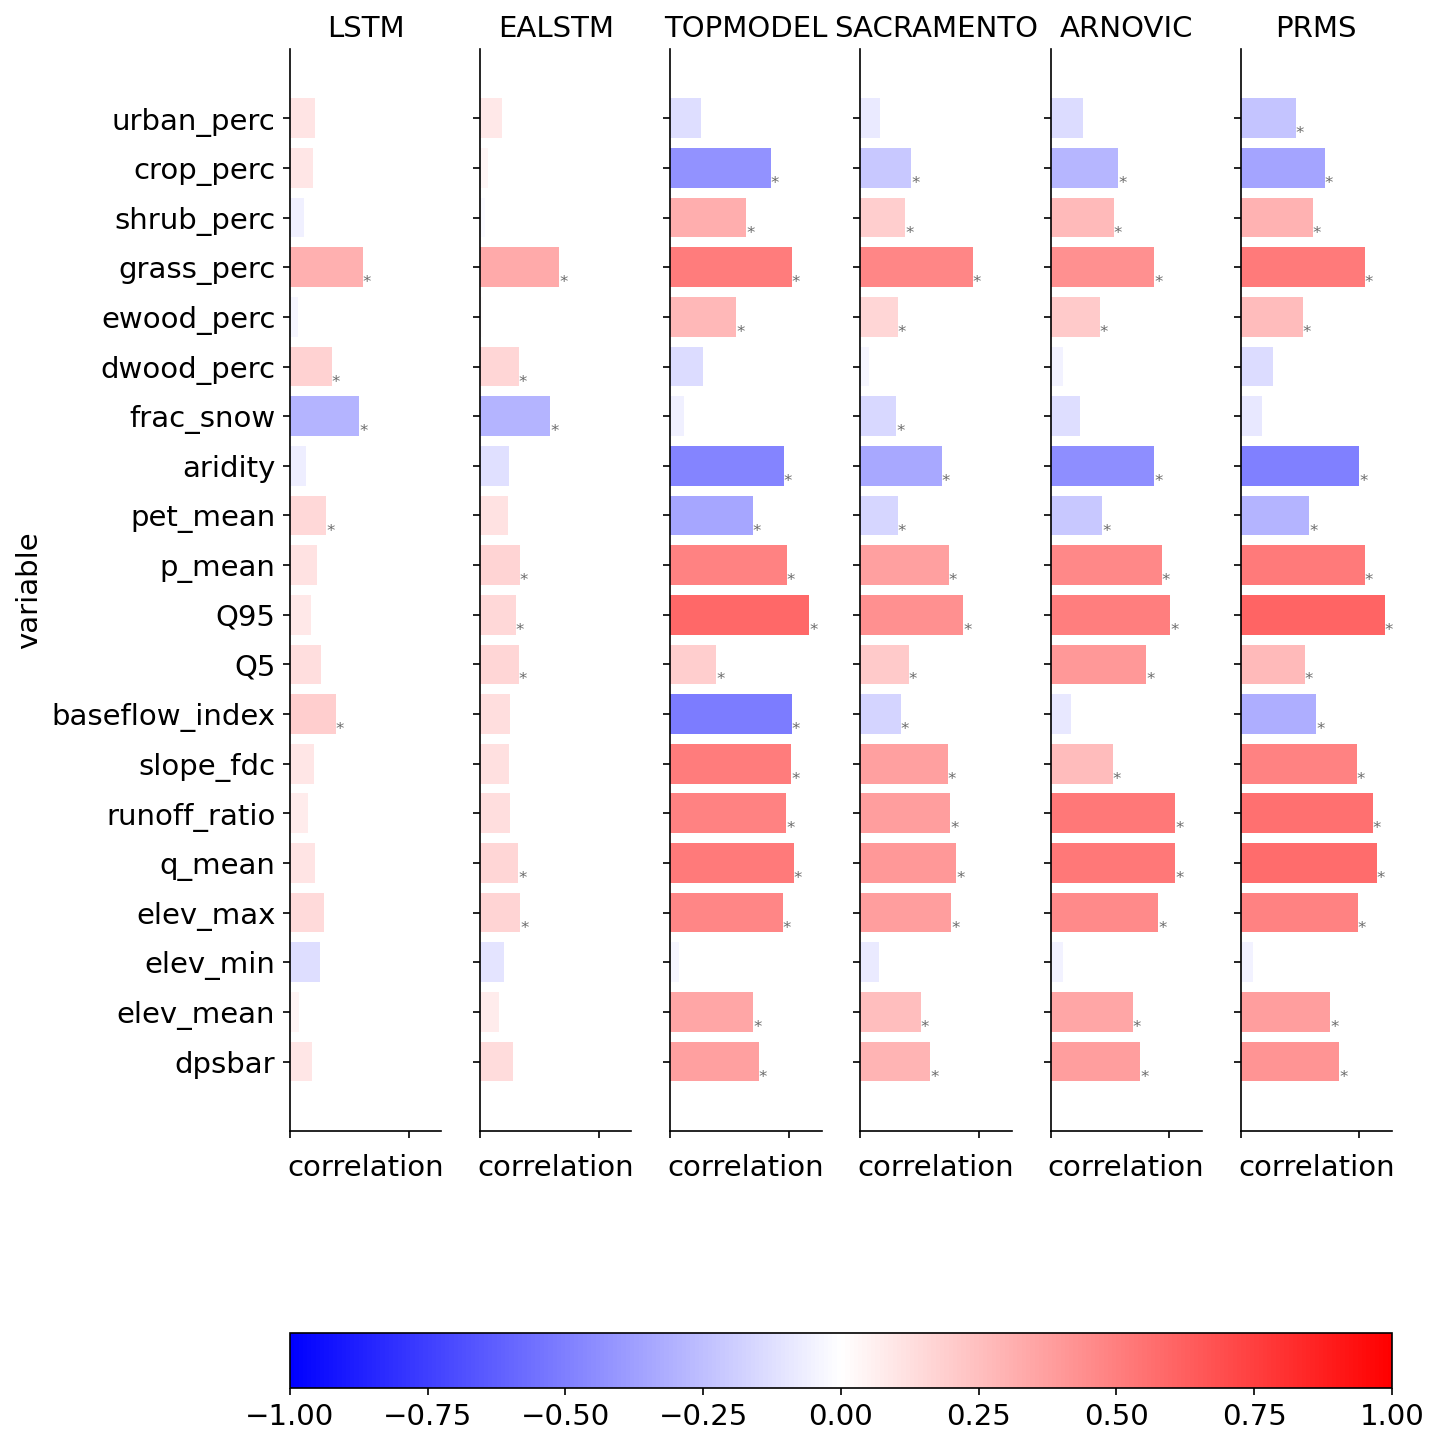

In [63]:
# https://stackoverflow.com/questions/65749781/create-a-table-of-multiple-mini-barplots-in-python/65750091#65750091

from matplotlib.colors import TwoSlopeNorm
from matplotlib.cm import ScalarMappable


def assign_to_significant_bars(significant: pd.Series):
    ax = plt.gca()
    # create a list to collect the plt.patches data
    totals = []

    # find the values and append to list
    for i in ax.patches:
        totals.append(i.get_width())

    # set individual bar lables using above list
    total = sum(totals)

    # set individual bar lables using above list
    significant = significant.to_list()
    list_of_patches = [i for ix, i in enumerate(ax.patches) if significant[ix]]
    for i in list_of_patches:
        # get_x pulls left or right; get_height pushes up or down
        ax.text(i.get_width(), i.get_y(), "*", fontsize=8, color='dimgrey')


# f, ax = plt.subplots(figsize=(12, 8))
norm = TwoSlopeNorm(vcenter=0, vmin=-1, vmax=1)
cmap = plt.get_cmap('bwr')

def my_bar_plot(x, y, significant, **kwargs):
    plt.barh(y=y, width=abs(x), color=cmap(norm(x)))
    assign_to_significant_bars(significant)
    ax = plt.gca()
    ax.set_xticklabels([""])

g = sns.FacetGrid(data=corr_df, col='model', height=5, aspect=0.16, sharex=True, sharey=True, size=10)
g.map(my_bar_plot, 'correlation', 'variable', "significant")
g.set_titles(col_template="{col_name}")
g.fig.colorbar(ScalarMappable(norm=norm, cmap=cmap), orientation='horizontal', ax=g.axes, fraction=0.05);


# Train test Period

In [64]:
train_period = pd.date_range("1988-01-01", "1997-12-31", freq="D")
test_period = pd.date_range("1998-01-01", "2008-12-31", freq="D")

In [65]:
variable = "discharge_spec"

train_ds = ds.sel(time=train_period)[["discharge_spec"]]
test_ds = ds.sel(time=test_period)[["discharge_spec"]]

In [66]:
from scripts.drafts.io_results import calculate_benchmarks
from scripts.drafts.calculate_error_scores import calculate_all_data_errors
PLOT_TR_TE = True


if PLOT_TR_TE:
    # benchmark_calculation_date_range = pd.date_range("1997-12-31", "2008-12-31", freq="D")
    # calculate_benchmarks(ds.sel(time=benchmark_calculation_date_range)[["discharge_spec"]])
    benchmarks = calculate_benchmarks(ds[["discharge_spec"]])
    test_obs = ds["discharge_spec"].sel(time=test_period)
    train_obs = ds["discharge_spec"].sel(time=train_period)

    test_bmark = benchmarks.sel(time=test_period)
    test_bmark["obs"] = test_obs
    train_bmark = benchmarks.sel(time=train_period)
    train_bmark["obs"] = train_obs

    # calculate error metrics from the sim/obs
    if not "test_errors" in globals():
        train_errors = calculate_all_data_errors(train_bmark)
        test_errors = calculate_all_data_errors(test_bmark)

        train_errors = xr.Dataset(train_errors).rename({"dim_1": "metric"})
        test_errors = xr.Dataset(test_errors).rename({"dim_1": "metric"})

    # get only the stations valid in both TEST and TRAIN periods
    stations = set(test_errors.station_id.values).intersection(set(train_errors.station_id.values))
    nse_test = test_errors.sel(metric="nse", station_id=list(stations))
    nse_train = train_errors.sel(metric="nse", station_id=list(stations))

Errors: 100%|██████████| 3/3 [01:39<00:00, 33.16s/it]


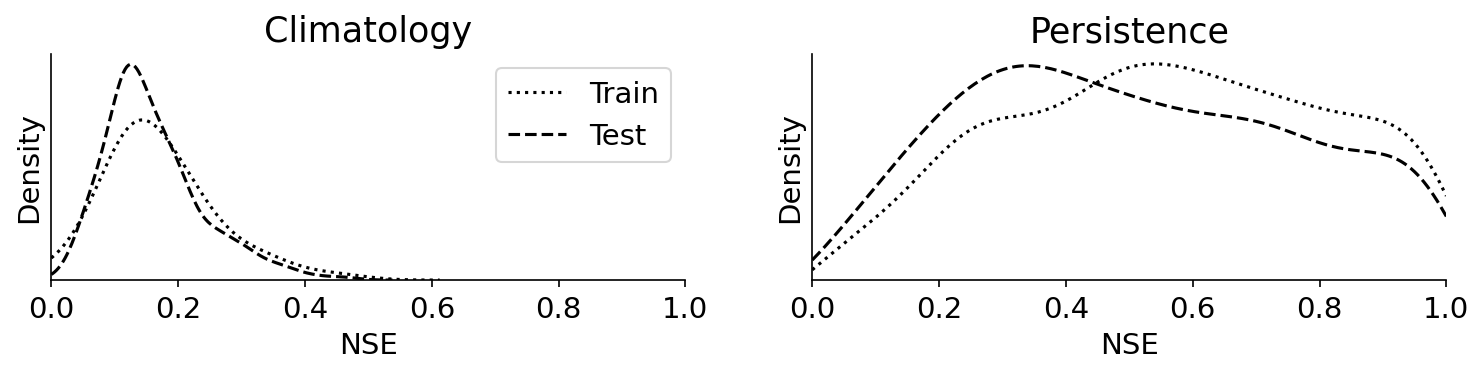

In [67]:
if PLOT_TR_TE:
    f, axs = plt.subplots(1, 2, figsize=(6*2, 4*0.5))
    for i, model in enumerate(["climatology_doy", "persistence"]):
        ax = axs[i]
        sns.distplot(nse_train[model], label="Train", hist=False, kde_kws=dict(clip=(0, 1), ls=":"), ax=ax, norm_hist=False, color="k")
        sns.distplot(nse_test[model], label="Test", hist=False, kde_kws=dict(clip=(0, 1), ls="--"), ax=ax, norm_hist=False, color="k")
        sns.despine()
        ax.set_xlim(0, 1)
        ax.set_yticklabels([""])
        ax.set_yticks([])
        ax.set_xlabel("NSE")
        ax.legend()
        ax.set_title("Climatology" if model == "climatology_doy" else "Persistence")
        if i != 0:
            ax.get_legend().remove()

#### do key variables vary?

In [68]:
train_df = ds.sel(time=train_period)[["precipitation", "pet", "temperature", "discharge_spec"]].to_dataframe()
test_df = ds.sel(time=test_period)[["precipitation", "pet", "temperature", "discharge_spec"]].to_dataframe()

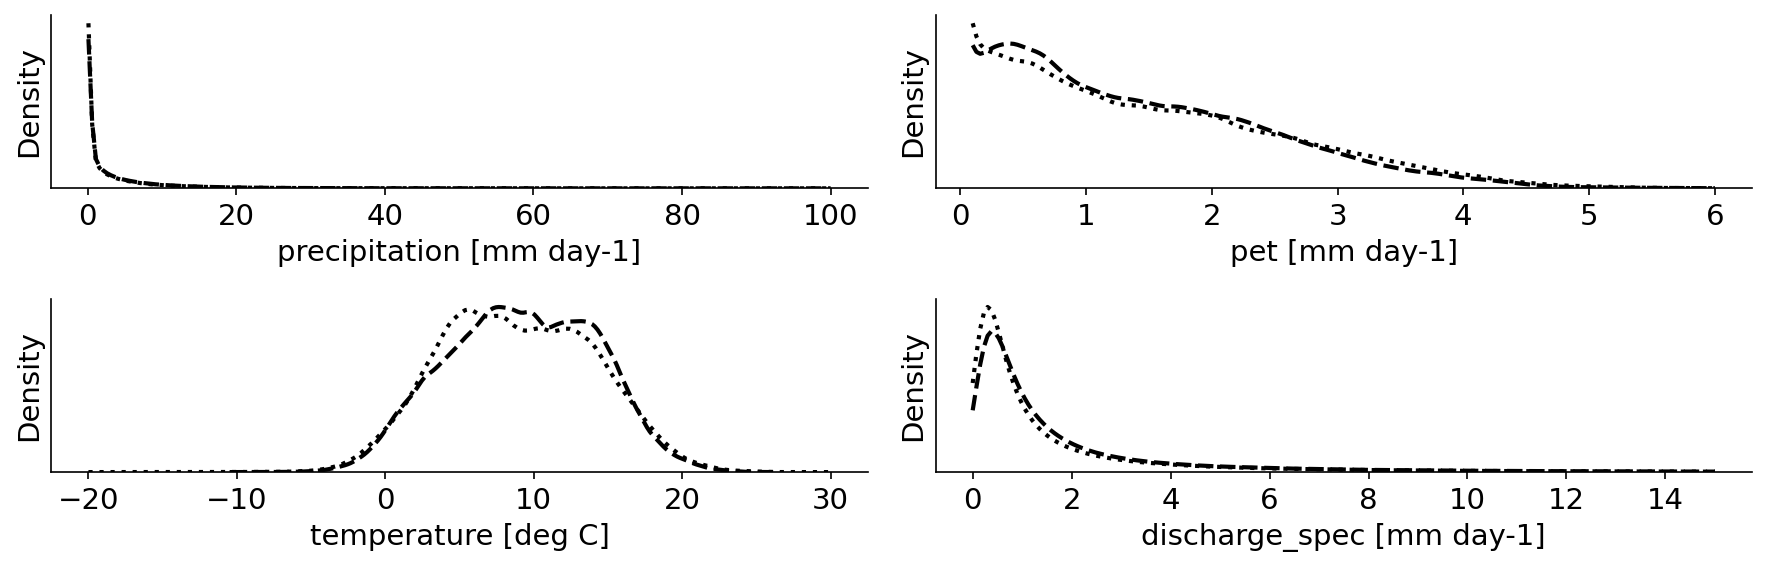

In [71]:
if PLOT_TR_TE:
    scale = 1.0
    var_kwargs = {
        "precipitation": {"clip": (0.1, 100)},
        "pet": {"clip": (0.1, 6)},
        "temperature": {"clip": (-20, 30)},
        "discharge_spec": {"clip": (0, 15)},
    }

    variables = ["precipitation", "pet", "temperature", "discharge_spec"]
    f, axs = plt.subplots(2, 2, figsize=(6*2*scale, 2*2*scale))

    for ix, variable in enumerate(variables):
        ax = axs[np.unravel_index(ix, (2,2))]

        sns.kdeplot(train_df[variable], label="Train", lw=2, clip=var_kwargs[variable]["clip"], ls=":", color="k", ax=ax)
        sns.kdeplot(test_df[variable], label="Test", lw=2, clip=var_kwargs[variable]["clip"], ls="--", color="k", ax=ax)
        label = f"{variable} [deg C]" if variable == "temperature" else f"{variable} [mm day-1]"
        ax.set_xlabel(label)
        ax.set_yticklabels([""])
        ax.set_yticks([])
        if ax.get_legend() is not None:
            ax.get_legend().remove()

        sns.despine()

        plt.tight_layout()

# Seasonal analysis

In [73]:
import pickle 
from scripts.drafts.calculate_error_scores import calculate_seasonal_errors

RELOAD = False

if RELOAD:
    seasonal_errors = calculate_seasonal_errors(all_preds)
    pickle.dump(seasonal_errors, (olddata_dir / "RUNOFF/seasonal_errors_LANE.pkl").open("wb"))
else:
    seasonal_errors = pickle.load((olddata_dir / "RUNOFF/seasonal_errors_LANE.pkl").open("rb"))
    
seasonal_metrics = defaultdict(dict)
for season in ["DJF", "MAM", "JJA", "SON"]:
    seasonal_metrics[season] = get_metric_dataframes_from_output_dict(seasonal_errors[season])

from scripts.drafts.calculate_error_scores import convert_season_to_xr
season_xr = convert_season_to_xr(seasonal_metrics)

In [74]:
season_xr

<xarray.Dataset>
Dimensions:                 (model: 6, season: 4, station_id: 518)
Coordinates:
  * season                  (season) <U3 'DJF' 'JJA' 'MAM' 'SON'
  * station_id              (station_id) int64 1001 2001 2002 ... 102001 106001
  * model                   (model) object 'TOPMODEL' 'ARNOVIC' ... 'EALSTM'
Data variables: (12/23)
    sqrt_variability_ratio  (season, station_id, model) float64 0.9699 ... 0....
    inv_variability_ratio   (season, station_id, model) float64 0.9918 ... 0....
    variability_ratio       (season, station_id, model) float64 0.9022 ... 0....
    sqrt_correlation        (season, station_id, model) float64 0.7963 ... 0....
    inv_correlation         (season, station_id, model) float64 0.7551 ... 0....
    sqrt_bias_ratio         (season, station_id, model) float64 0.9558 ... 0....
    ...                      ...
    bias                    (season, station_id, model) float64 -8.336 ... -7...
    mape                    (season, station_id, model) float64 34.51 ... 31.39
    rmse                    (season, station_id, model) float64 1.366 ... 1.517
    nse                     (season, station_id, model) float64 0.5465 ... 0....
    kge                     (season, station_id, model) float64 0.7287 ... 0....
    mse                     (season, station_id, model) float64 1.865 ... 2.301

# Calculate ∆Metrics

In [75]:
from scripts.drafts.calculate_error_scores import calculate_all_delta_dfs

seasonal_deltas = defaultdict(dict)
for month in ["DJF", "MAM", "JJA", "SON"]:
    seasonal_deltas[month]["LSTM"], seasonal_deltas[month]["EALSTM"] = calculate_all_delta_dfs(seasonal_metrics[month])

### Seasonal CDFs

In [76]:
from typing import DefaultDict, Tuple


def plot_seasonal_ecdfs(seasonal_deltas: DefaultDict, metric: str = "nse", ref_model: str = "LSTM", clip: Tuple[float] = (-1, 3), legend_all: bool = False):
    fig, axs = plt.subplots(1, 4, figsize=(6*4, 4*1))

    for ix, model in enumerate(["TOPMODEL", "ARNOVIC", "PRMS", "SACRAMENTO"]):
        ax = axs[np.unravel_index(ix, (4))]
        for season in ["DJF", "MAM", "JJA", "SON"]:
            sns.distplot(
                seasonal_deltas[season][ref_model][metric].loc[:, model].dropna(), 
                label=season, 
                kde_kws = {"clip": (-1, 3), "linewidth":1, "cumulative": True}, 
                hist=False, ax=ax
            )

            ax.axvline(0, ls=":", color="k", alpha=0.6)
            ax.set_xlabel(f"$\Delta${metric.upper()} ({ref_model})")
            ax.set_title(model)
            if not legend_all:
                if ix != 0:
                    if ax.get_legend() is not None:
                        ax.get_legend().remove()

            sns.despine()
            ax.set_xlim(clip)

    plt.tight_layout()


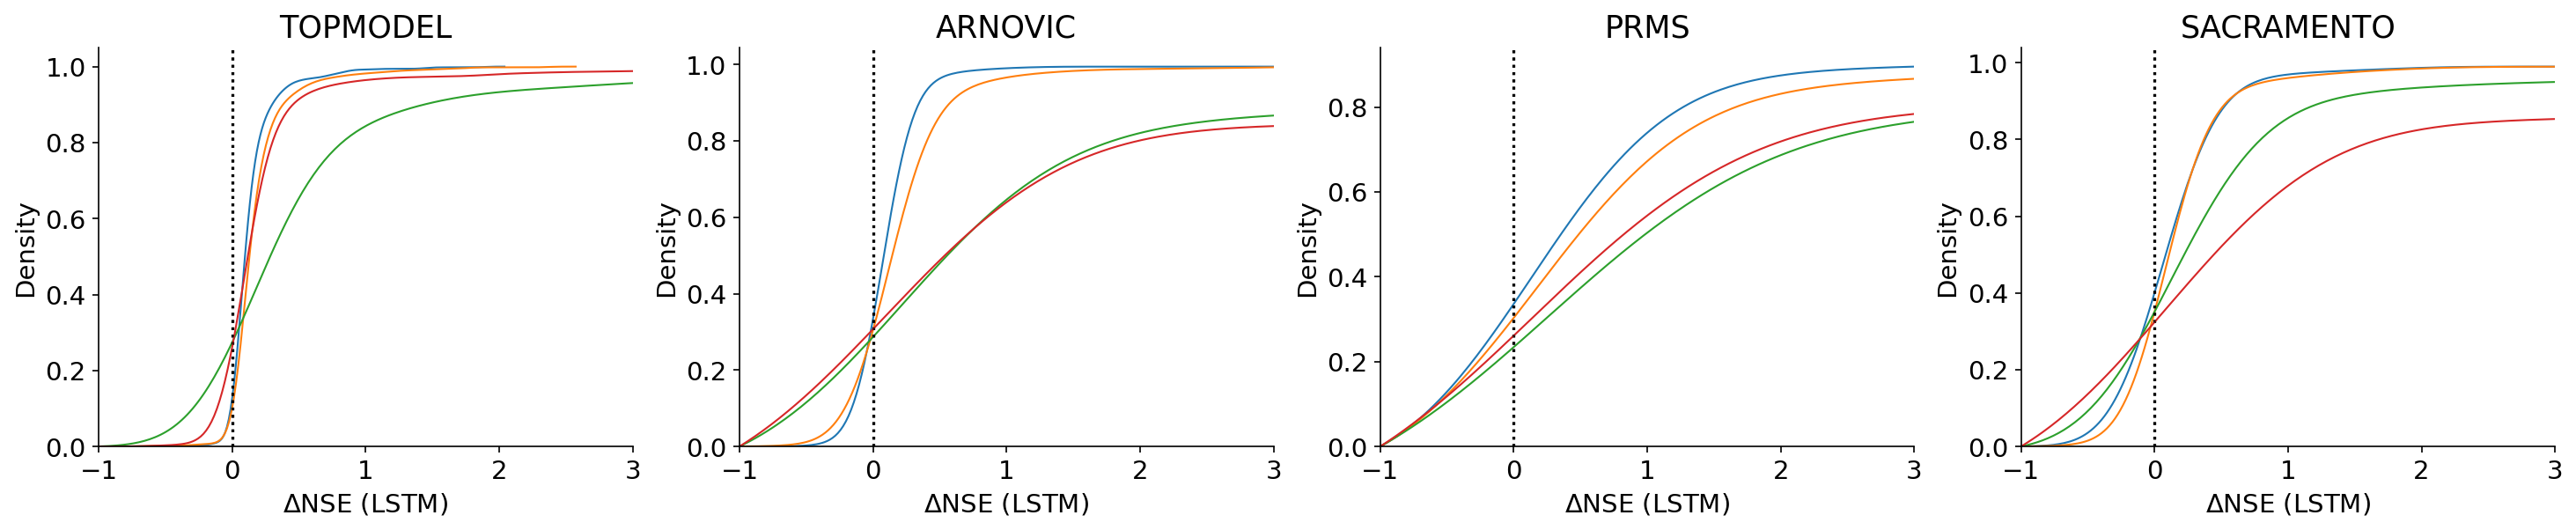

In [77]:
ref_model = "LSTM"
legend_all = False
metric = "nse"
fig, axs = plt.subplots(1, 4, figsize=(6*4, 4*1))
clip = (-1, 3)

for ix, model in enumerate(["TOPMODEL", "ARNOVIC", "PRMS", "SACRAMENTO"]):
    ax = axs[np.unravel_index(ix, (4))]
    for season in ["DJF", "MAM", "JJA", "SON"]:
        sns.distplot(
            seasonal_deltas[season][ref_model][metric].loc[:, model].dropna(), 
            label=season, 
            kde_kws = {"clip": (-1, 3), "linewidth":1, "cumulative": True}, 
            hist=False, ax=ax
        )

        ax.axvline(0, ls=":", color="k", alpha=0.6)
        ax.set_xlabel(f"$\Delta${metric.upper()} ({ref_model})")
        ax.set_title(model)
        if not legend_all:
            if ix != 0:
                if ax.get_legend() is not None:
                    ax.get_legend().remove()

        sns.despine()
        ax.set_xlim(clip)


### Seasonal Maps

In [86]:
metric = "nse"

season_df = create_geospatial_data(season_xr[metric].to_dataframe().reset_index()).set_index("station_id")
if "season" not in season_df.columns:
    season_df = season_df.rename({"level_0": "season"}, axis=1)
for model in ["LSTM", "EALSTM", "SACRAMENTO", "ARNOVIC", "TOPMODEL", "PRMS"]:
    kwargs = opts[metric]
    metric_data = season_df.loc[season_df["model"] == model]
    plot_metric_data_per_season(metric_data, metric=metric, legend=False, kwargs=kwargs)
    if model == "EALSTM":
        break

ValueError: cannot convert float NaN to integer

ValueError: cannot convert float NaN to integer

## Correlations PER SEASON

In [87]:
metric = "nse"
corr_dfs = []

for season in ["DJF", "MAM", "JJA", "SON"]:
    metric_data = seasonal_metrics[season][metric]
    corr_df = calc_correlation_dataframe(metric_data)
    corr_df["season"] = season
    corr_dfs.append( corr_df)
    
season_corr_df = pd.concat(corr_dfs, axis=0)

In [88]:
season_corr_df.head()

correlation    pvalue   variable model  significant  positive season
0    -0.006605  0.880787     dpsbar  LSTM        False     False    DJF
1    -0.072257  0.100443  elev_mean  LSTM        False     False    DJF
2    -0.127773  0.003580   elev_min  LSTM        False     False    DJF
3     0.014536  0.741352   elev_max  LSTM        False      True    DJF
4     0.008190  0.852482     q_mean  LSTM        False      True    DJF

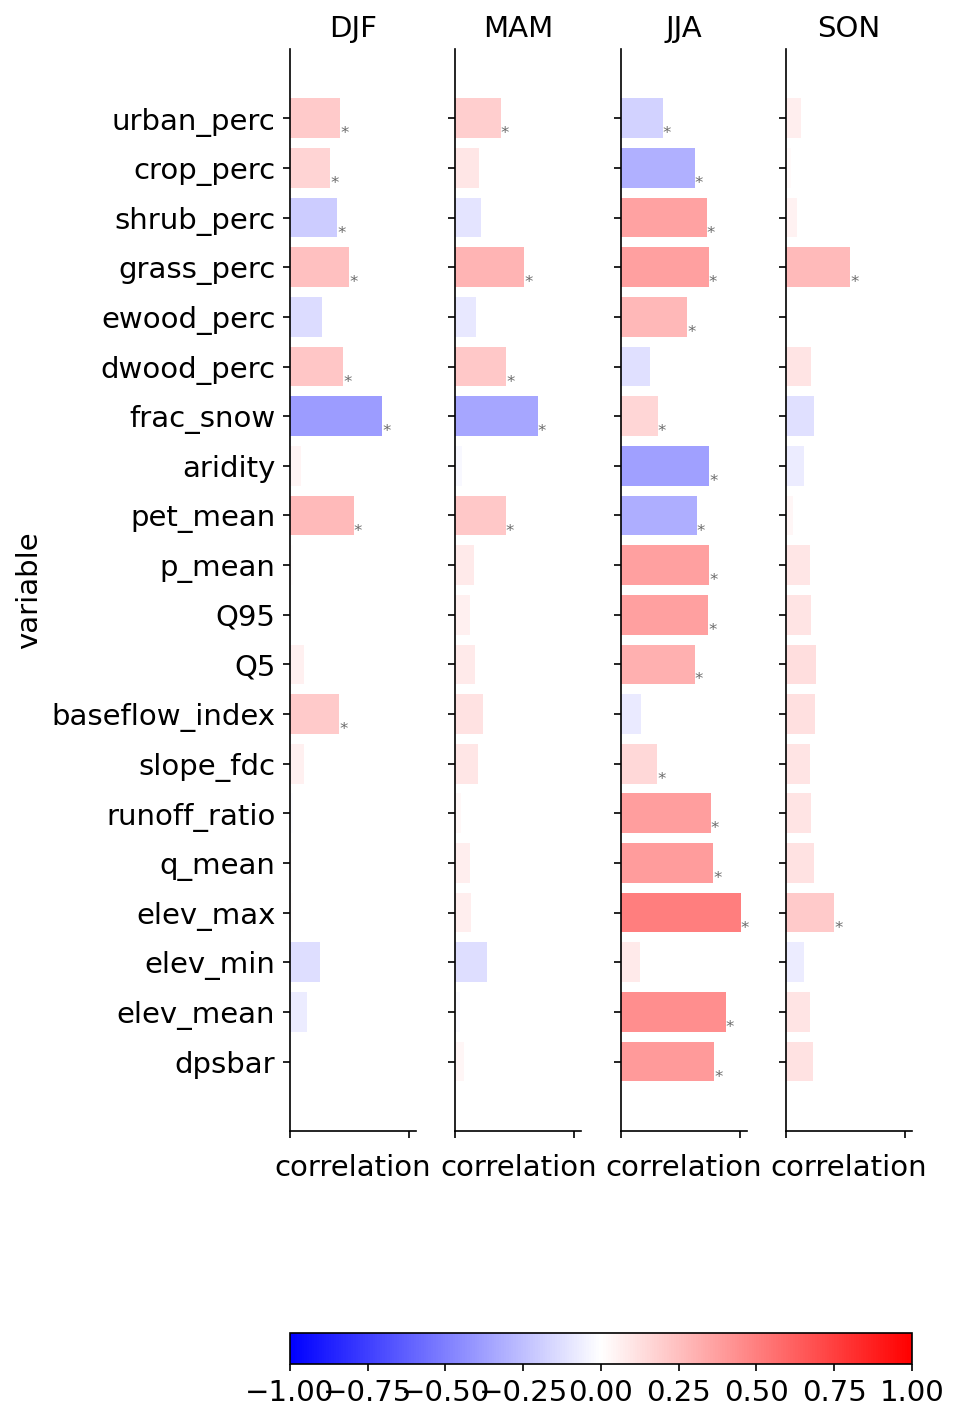

In [89]:
# https://stackoverflow.com/questions/65749781/create-a-table-of-multiple-mini-barplots-in-python/65750091#65750091
df_ = season_corr_df.loc[season_corr_df["model"] == "LSTM"]
g = sns.FacetGrid(data=df_, col='season', height=5, aspect=0.16, sharex=True, sharey=True, size=10)
g.map(my_bar_plot, 'correlation', 'variable', "significant")
g.set_titles(col_template="{col_name}")
g.fig.colorbar(ScalarMappable(norm=norm, cmap=cmap), orientation='horizontal', ax=g.axes, fraction=0.05);